<a href="https://colab.research.google.com/github/YoungsikMoon/FORS/blob/main/%EB%AC%B8%EC%98%81%EC%8B%9D/FORS_%EB%AC%B8%EC%98%81%EC%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PCM 파일 핸들링 코드 모음

참고 : https://noggame.tistory.com/15

## pcm을 wav로 변환하는 코드

PCM 데이터를 WAV로 변환하려는 경우 WAV 파일이 어떻게 쓰였는지 나타내는 Header가 필요하다. Header에는 samplerate나 소리 데이터의 길이 등의 정보가 들어가며, 직접 구현하기보다는 numpy, librosa, soundfile 등의 라이브러리를 사용하면 간단히 해결 가능하다.

In [ ]:
import numpy as np
import librosa as lr
import soundfile as sf

target = "/content/KsponSpeech_000001.pcm" # 타깃 파일 경로
destinationPath = "/content/KsponSpeech_000001.wav" #만들 파일 경로
buf = None

with open(target, 'rb') as tf:
    buf = tf.read()
    buf = buf+b'0' if len(buf)%2 else buf    # padding 0 (경우에 따라서 PCM 파일의 길이가 8bit[1byte]로 나누어 떨어지지 않는 경우가 있어 0으로 패딩값을 더해준다, 해당 처리를 하지 않는 경우 numpy나 librosa 라이브러리 사용 시 오류가 날 수 있다)

pcm_data = np.frombuffer(buf, dtype='int16')
wav_data = lr.util.buf_to_float(x=pcm_data, n_bytes=2)
sf.write(destinationPath, wav_data, 16000, format='WAV', endian='LITTLE', subtype='PCM_16')

## wav 파일을 pcm 으로 변환하는 코드

PCM과 WAV의 소리 데이터 부분은 동일하고, Header 부분만 차이가 나므로 WAV 파일에서 (Header를 제외한) 데이터 부분만 읽어서 파일로 만들면 PCM 파일에 해당한다.

In [ ]:
target = "{대상파일_경로}"
destinationPath = target[:-4]+".pcm" # {생성파일경로}
buf = None

with open(destinationPath, "wb") as d_file:
    t_file = open(target, "rb")
    t_bin = t_file.read()
    d_file.write(t_bin[44:])    # header 이외의 데이터를 pcm 파일로 저장
    t_file.close()

## pcm 파일 통합 하는 코드

PCM은 파일의 시작에 소리 정보를 담고있는 header가 존재하지 않기 때문에, raw 데이터(Byte Code)를 그대로 읽어서 합치면된다.

In [ ]:
targetList = ["{대상파일1_경로}", "{대상파일2_경로}"]
destinationPath = "{생성파일경로}"

buf = bytearray()
for file in targetList:
    f = open(file, 'rb')
    buf += f.read()
    f.close()

wf = open(destinationPath, 'wb')
wf.write(buf)
wf.close()



---



# OpenAI WhisperAI STT (오래걸림)

위스퍼 설치

In [ ]:
pip install openai-whisper

한국어 모델 다운로드하기

In [ ]:
!whisper-cli --model ko --download-dir .

음성 파일 변환하기

변환할 한국어 음성 파일을 준비합니다.
다음 Python 코드를 실행하여 음성 파일을 텍스트로 변환합니다:

In [ ]:
import whisper

# 모델 로드
model = whisper.load_model("small")


결과 확인하기

위 코드를 실행하면 음성 파일의 텍스트 인식 결과가 출력됩니다.
인식 결과는 result['text']에 저장됩니다.

OpenAI Whisper는 다양한 언어를 지원하며, 특히 한국어 모델의 성능이 우수합니다. 이를 활용하면 다양한 음성 기반 애플리케이션을 개발할 수 있습니다.

추가로, Whisper는 다음과 같은 특징이 있습니다:

지원 언어: 총 98개 언어 지원 (한국어 포함)

모델 크기: 작은 모델부터 대형 모델까지 다양한 옵션 제공

사용 요금: 무료로 사용 가능

---



In [ ]:

# 음성 파일 경로 설정
audio_file = "/content/KsponSpeech_000001.wav"

# 음성 파일 변환
result = model.transcribe(audio_file)
print(f"인식 결과: {result['text']}")



---



# NVIDIA NeMo STT (1초)

참고 git : https://github.com/NVIDIA/NeMo

참고 문서 : https://huggingface.co/eesungkim/stt_kr_conformer_transducer_large

모델을 훈련하고, 미세 조정하고, 플레이하려면 NVIDIA NeMo를 설치해야 합니다 . 최신 Pytorch 버전을 설치한 후 설치하는 것이 좋습니다.

In [ ]:
!pip install nemo_toolkit['all']

이 모델은 NeMo 툴킷[1](https://github.com/NVIDIA/NeMo)에서 사용할 수 있으며 추론을 위해 사전 훈련된 체크포인트로 사용하거나 다른 데이터 세트에 대한 미세 조정을 수행할 수 있습니다.


자동으로 모델 인스턴스화

In [ ]:
import nemo.collections.asr as nemo_asr
asr_model = nemo_asr.models.ASRModel.from_pretrained("eesungkim/stt_kr_conformer_transducer_large")

음성파일 텍스트로 전환

In [ ]:
asr_model.transcribe(['KsponSpeech_000001.wav'])

많은 오디오 파일을 텍스트로 변환

In [ ]:
!python [NEMO_GIT_FOLDER]/examples/asr/transcribe_speech.py  pretrained_name="eesungkim/stt_kr_conformer_transducer_large"  audio_dir="<오디오 디렉터리>"

# 음성메모 프로그램 만들기

참고 : https://pagichacha.tistory.com/103

음성으로 말을하면 자동으로 기록해주는 메모 프로그램.

---



시나리오

1. 음성내용을 텍스트로  변환 후 파일 메모로 저장.
- 안내방송 (텍스트-음성 처리) 후 우리가 음성으로 말한 내용을 텍스ㅡ트로 변환 후 파일로 저장하는 방법에 대하여 살펴봅시다.

2. 위 1번 내용에서 음성이 끝나기 전까지 지속적으로 녹음되도록 개선
- 위의 1번의 경우 한번 말하면 끝이 나므로 다시 프로그램을 시작해야 하는 불편사항이 존재합니다. 따라서 우리가 특정 명령을 내리기 저까지는 계속 실행되어 메모를 진행할 수 있도록 대선하는 방법에 대하여 알아보겠습니다.



---



프로그램 실행하기 위한 모듈 임포트.

In [ ]:
!pip install SpeechRecognition #음성인식

In [ ]:
!pip install gTTS #텍스트를 음성으로 만들 수 있다.

In [ ]:
!pip install pygame #음성 재생 기능

In [ ]:
import speech_recognition as sr
from gtts import gTTS
import os
import time
import pygame
import os

In [ ]:


def speak(text):
    tts = gTTS(text=text, lang='ko')
    filename='voice.mp3'
    tts.save(filename)
    pygame.init()
    pygame.mixer.music.load(filename)
    pygame.mixer.music.play()
    while pygame.mixer.music.get_busy():
        continue
    pygame.mixer.music.unload()
    time.sleep(1) # 1초 지연
    os.remove(filename)


def get_audio():
    r = sr.Recognizer()
    with sr.Microphone() as source:
        print("지금 말씀하세요: ")
        audio = r.listen(source)
        said = " "

        try:
            said = r.recognize_google(audio, language="ko-KR")
            print("말씀하신 내용입니다 : ", said)
        except Exception as e:
            print("Exception: " + str(e))

    return said

#############################
# 0.안내 방송(음성)
#############################
if os.path.isfile('memo.txt'):
    os.remove('memo.txt')
speak("안녕하세요. 2초 후에 말씀하세요. 종료시 굿바이 라고 말씀하시면 됩니다.")

while True:
#############################
# 1.음성입력
#############################
    text=get_audio()
    print(text)

#############################
# 5.파일저장
#############################
    with open('memo.txt', 'a') as f:
        f.write(str(text)+"\n")

    if "굿바이" in text:
        break

time.sleep(0.1)

# WhisperAI fine-tuning 하는 코드 (한국어.ver)

참고 : https://huggingface.co/blog/fine-tune-whisper

매우 친절하고 꼼꼼하게 설명해줄게요.

* 안녕하세요. 사용자 여러분, 이번에는 Whisper 모델을 다국어 음성 인식 데이터셋에 fine-tuning하는 방법에 대해 자세히 알아보겠습니다.

* Whisper는 OpenAI가 개발한 엔드-투-엔드 음성 인식 모델로, 높은 정확도와 실시간 전사 기능으로 유명합니다. 이번 가이드에서는 Hugging Face Transformers 라이브러리를 사용하여 Whisper 모델을 fine-tuning하는 방법을 단계별로 설명드리겠습니다.
[blog post](https://huggingface.co/blog/fine-tune-whisper).

## 소개



*   Whisper
    * Whisper는 OpenAI에서 개발한 자동 음성 인식(ASR) 모델로, 2022년 9월에 공개되었습니다.
    *  이 모델은 680,000시간 분량의 방대한 양의 레이블링된 오디오-전사 데이터로 사전 학습되었습니다.
    * Whisper 모델은 다양한 데이터셋과 도메인에 강력한 일반화 능력을 보여줍니다.

<figure>
<img src="https://raw.githubusercontent.com/sanchit-gandhi/notebooks/main/whisper_architecture.svg" alt="Trulli" style="width:100%">
<figcaption align = "center"><b>그1:</b> Whisper model.</figcaption>

* Whisper 모델의 아키텍처는 표준적인 Transformer 기반의 인코더-디코더 모델을 따르고 있습니다.
* 입력으로는 로그-멜 스펙트로그램이 사용됩니다.
* 인코더의 마지막 은닉 상태가 크로스 어텐션 메커니즘을 통해 디코더로 전달됩니다.
* 디코더는 이전에 예측된 토큰들과 인코더 은닉 상태를 함께 고려하여 텍스트 토큰을 자동 회귀적으로 예측합니다.
<a href="https://openai.com/blog/whisper/">OpenAI Whisper Blog</a>.
</figure>

* 다양한 모델 크기의 5가지 구성.
    1. 가장 작은 4개는 영어 전용 또는 다국어 데이터로 훈련되었습니다.
    2. 가장 큰 체크포인트는 다국어 가능합니다.
    
* 사전 훈련된 11개의 체크포인트는 모두 허깅 페이스 허브에서 이용 가능합니다. [Hugging Face Hub](https://huggingface.co/models?search=openai/whisper).

* 체크포인트는 허브의 모델에 대한 링크와 함께 다음 표에 요약되어 있습니다.

| Size (크기)     | Layers (레이어) | Width (폭) | Heads (해드) | Parameters (파라미터) | English-only (영어전용)                                         | Multilingual (다국어)                                        |
|----------|--------|-------|-------|------------|------------------------------------------------------|-----------------------------------------------------|
| tiny     | 4      | 384   | 6     | 39 M       | [✓](https://huggingface.co/openai/whisper-tiny.en)   | [✓](https://huggingface.co/openai/whisper-tiny.)    |
| base     | 6      | 512   | 8     | 74 M       | [✓](https://huggingface.co/openai/whisper-base.en)   | [✓](https://huggingface.co/openai/whisper-base)     |
| small    | 12     | 768   | 12    | 244 M      | [✓](https://huggingface.co/openai/whisper-small.en)  | [✓](https://huggingface.co/openai/whisper-small)    |
| medium   | 24     | 1024  | 16    | 769 M      | [✓](https://huggingface.co/openai/whisper-medium.en) | [✓](https://huggingface.co/openai/whisper-medium)   |
| large    | 32     | 1280  | 20    | 1550 M     | x                                                    | [✓](https://huggingface.co/openai/whisper-large)    |
| large-v2 | 32     | 1280  | 20    | 1550 M     | x                                                    | [✓](https://huggingface.co/openai/whisper-large-v2) |
| large-v3 | 32     | 1280  | 20    | 1550 M     | x                                                    | [✓](https://huggingface.co/openai/whisper-large-v3) |


* 다국어 버전의 미세 조정
[small](https://huggingface.co/openai/whisper-small) 244M 매개변수(~= 1GB)가 있는 체크포인트입니다.
* 저자원 언어로 시스템을 훈련하고 평가합니다.
[Common Voice](https://huggingface.co/datasets/mozilla-foundation/common_voice_11_0)에서 가져옴
데이터세트.
* Whisper AI를 8시간 동안 미세 조정하면 노인을 위한 한국어에서 강력한 성능을 얻을 수 있습니다.

## 환경 준비


* GPU 설정
    * _런타임_ -> _런타임 유형 변경_을 클릭한 다음 _하드웨어 가속기_를 _CPU_에서 사용 가능한 GPU 중 하나로 변경합니다. _T4_(또는 사용 가능한 것이 있으면 더 좋습니다). 그런 다음 화면 오른쪽 상단에 있는 'T4 연결'을 클릭하세요(또는 다른 GPU를 선택한 경우 {V100, A100} 연결').

GPU가 할당되었는지 확인하고 해당 사양을 볼 수 있습니다.:

In [ ]:
# GPU 정보 확인을 위해 nvidia-smi 명령어를 실행하여 GPU 정보를 가져옵니다.
# nvidia-smi는 NVIDIA 그래픽 카드의 상태 정보를 출력하는 명령어입니다.
gpu_info = !nvidia-smi

# 가져온 GPU 정보를 개행 문자로 연결하여 문자열로 변환합니다.
# 명령어 실행 결과는 리스트 형태로 반환되므로, 이를 문자열로 변환합니다.
gpu_info = '\n'.join(gpu_info)

# GPU 정보에 'failed' 문자열이 포함되어 있는지 확인하여 GPU 연결 상태를 판별합니다.
# 'failed' 문자열이 포함되어 있으면 GPU에 연결되지 않은 것으로 간주합니다.
if gpu_info.find('failed') >= 0:
  # 'failed' 문자열이 포함되어 있으면 GPU에 연결되지 않았음을 출력합니다.
  print('Not connected to a GPU')
else:
  # 'failed' 문자열이 포함되어 있지 않으면 GPU 정보를 출력합니다.
  print(gpu_info)

# 이 코드는 GPU 정보를 확인하기 위해 nvidia-smi 명령어를 사용하고, 그 결과를 파이썬 코드로 처리하여 GPU 연결 상태를 판별합니다. 만약 GPU에 연결되지 않았을 경우 "Not connected to a GPU"를 출력하고, GPU에 연결되어 있을 경우에는 실제 GPU 정보를 출력합니다.

* Pytohn 패키지 사용
    1. `datasets[audio]`를 사용하여 훈련 데이터를 다운로드하고 준비합니다.
    2. Whisper 모델을 로드하고 훈련하기 위한 'Transformers' 및 'accelerate'
    3. 오디오 파일을 전처리하는 `soundfile` 패키지
    4. 모델의 성능을 평가하기 위한 '평가' 및 'jiwer'
    5. 측정항목을 기록하는 '텐서보드'
    6. `gradio`를 빌드합니다.
미세 조정된 모델의 화려한 데모입니다.

In [ ]:
# pip를 최신 버전으로 업그레이드합니다.
# --quiet 옵션은 출력을 최소화하여 조용히 실행하도록 합니다.
!pip install --upgrade --quiet pip

# datasets, transformers, accelerate, evaluate, jiwe, tensorboard, gradio 등의 라이브러리를 최신 버전으로 업그레이드합니다.
# [audio] 옵션은 datasets 라이브러리에서 오디오 데이터셋을 사용하기 위한 추가 패키지를 설치합니다.
# --quiet 옵션은 출력을 최소화하여 조용히 실행하도록 합니다.
!pip install --upgrade --quiet datasets[audio] transformers accelerate evaluate jiwer tensorboard gradio

# 이 코드는 다음과 같은 기능을 수행합니다:
# pip 업그레이드: 시스템의 pip 패키지 관리자를 최신 버전으로 업그레이드합니다. --quiet 옵션을 사용하여 출력을 최소화하고 조용히 실행합니다.

# 라이브러리 업그레이드: 다음과 같은 라이브러리를 최신 버전으로 업그레이드합니다:
# datasets: 데이터셋 관리 라이브러리
# transformers: 자연어 처리 모델 라이브러리
# accelerate: 모델 학습 가속화 라이브러리
# evaluate: 모델 평가 라이브러리
# jiwer: 음성 인식 성능 평가 라이브러리
# tensorboard: 텐서플로 기반 시각화 라이브러리
# gradio: 웹 기반 대화형 UI 라이브러리
# [audio] 옵션은 datasets 라이브러리에서 오디오 데이터셋을 사용하기 위한 추가 패키지를 설치합니다. --quiet 옵션을 사용하여 출력을 최소화하고 조용히 실행합니다.

# 이 코드는 AI 및 머신러닝 프로젝트에 필요한 주요 라이브러리를 최신 버전으로 업그레이드하여 최신 기능과 성능을 활용할 수 있도록 합니다.

In [ ]:
# spacy 3.7.4 버전에서는 typer 라이브러리의 0.3.0 이상 0.10.0 미만 버전이 필요합니다.
# 그러나 호환되지 않는 typer 0.12.3 버전이 설치되어 있습니다.
# 따라서 typer 라이브러리를 0.9.1 버전으로 다운그레이드하여 호환성 문제를 해결합니다.
!pip install typer==0.9.1


# 이 코드는 다음과 같은 기능을 수행합니다:
# typer 라이브러리 다운그레이드: spacy 3.7.4 버전에서는 typer 라이브러리의 0.3.0 이상 0.10.0 미만 버전이 필요합니다.
# 그러나 호환되지 않는 typer 0.12.3 버전이 설치되어 있습니다.
# 따라서 typer 라이브러리를 0.9.1 버전으로 다운그레이드하여 호환성 문제를 해결합니다.

# 이 코드는 spacy와 관련된 호환성 문제를 해결하기 위해 typer 라이브러리를 특정 버전으로 다운그레이드하는 작업을 수행합니다.

In [ ]:
# tensorflow 2.15.0 버전에서는 tensorboard 라이브러리의 2.15 이상 2.16 미만 버전이 필요합니다.
# 그러나 호환되지 않는 tensorboard 2.16.2 버전이 설치되어 있습니다.
# 따라서 tensorboard 라이브러리를 2.15.0 버전으로 다운그레이드하여 호환성 문제를 해결합니다.
!pip install tensorboard==2.15.0

# 이 코드는 다음과 같은 기능을 수행합니다:
# tensorboard 라이브러리 다운그레이드: tensorflow 2.15.0 버전에서는 tensorboard 라이브러리의 2.15 이상 2.16 미만 버전이 필요합니다.
# 그러나 호환되지 않는 tensorboard 2.16.2 버전이 설치되어 있습니다.
# 따라서 tensorboard 라이브러리를 2.15.0 버전으로 다운그레이드하여 호환성 문제를 해결합니다.

# 이 코드는 tensorflow와 관련된 호환성 문제를 해결하기 위해 tensorboard 라이브러리를 특정 버전으로 다운그레이드하는 작업을 수행합니다.

In [ ]:
# weasel 0.3.4 버전에서는 typer 라이브러리의 0.3.0 이상 0.10.0 미만 버전이 필요합니다.
# 그러나 호환되지 않는 typer 0.12.3 버전이 설치되어 있습니다.
# 따라서 weasel 라이브러리를 0.3.4 버전으로 설치하여 호환성 문제를 해결합니다.
!pip install weasel==0.3.4


# 이 코드는 다음과 같은 기능을 수행합니다:
# weasel 라이브러리 설치: weasel 0.3.4 버전에서는 typer 라이브러리의 0.3.0 이상 0.10.0 미만 버전이 필요합니다.
# 그러나 호환되지 않는 typer 0.12.3 버전이 설치되어 있습니다.
# 따라서 weasel 라이브러리를 0.3.4 버전으로 설치하여 호환성 문제를 해결합니다.

# 이 코드는 weasel 라이브러리와 관련된 호환성 문제를 해결하기 위해 weasel 라이브러리를 특정 버전으로 설치하는 작업을 수행합니다.

* 모델 체크포인트를 [Hugging Face Hub](https://huggingface.co/)에 직접 업로드하세요.
훈련하는 동안.

* 허브는 다음을 제공합니다:
    - 통합 버전 제어: 학습 중에 모델 체크포인트가 손실되지 않도록 할 수 있습니다.
    - Tensorboard 로그: 훈련 과정에서 중요한 측정항목을 추적합니다.
    - 모델 카드: 모델이 수행하는 작업과 의도된 사용 사례를 문서화합니다.
    - 커뮤니티: 커뮤니티와 쉽게 공유하고 협업할 수 있는 방법입니다!

- 노트북을 허브에 연결하는 것은 간단합니다.

* 당신의 입력
메시지가 표시되면 허브 인증 토큰입니다. Hub 인증 토큰을 [여기](https://huggingface.co/settings/tokens)에서 찾으세요.

In [ ]:
# Huggingface 로그인
from huggingface_hub import notebook_login
notebook_login()

## 데이터 로드


* 🤗 데이터세트를 이용하여 데이터 다운로드 및 준비

    1. Hugging Face Hub: [mozilla-foundation/common_voice_12_0](https://huggingface.co/datasets/mozilla-foundation/common_voice_12_0)의 사용 약관에 동의했는지 확인하세요.

    2. 5시간 분량의 한국 데이터 세트는 리소스가 부족한 것으로 판단되어 [AI 허브](https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&dataSetSn)의 데이터 세트를 사용하기로 결정했습니다. =123) 2000명의 스피커로 1000시간 이상을 진행했습니다.

In [ ]:
# datasets 라이브러리를 사용하여 데이터셋을 로드합니다.
from datasets import load_dataset, DatasetDict

# DatasetDict 객체를 생성합니다.
common_voice = DatasetDict()

# "mozilla-foundation/common_voice_12_0" 데이터셋에서 한국어(ko) 데이터를 로드합니다.
# "train+validation" 데이터를 "train" 데이터셋으로 사용합니다.
# "test" 데이터를 "test" 데이터셋으로 사용합니다.
# use_auth_token=True를 사용하여 Hugging Face 인증 토큰을 사용합니다.
common_voice["train"] = load_dataset("mozilla-foundation/common_voice_12_0", "ko", split="train+validation", use_auth_token=True)
common_voice["test"] = load_dataset("mozilla-foundation/common_voice_12_0", "ko", split="test", use_auth_token=True)

# 로드된 데이터셋을 출력합니다.
print(common_voice)


# 이 코드는 다음과 같은 기능을 수행합니다:
# 데이터셋 로드: datasets 라이브러리를 사용하여 "mozilla-foundation/common_voice_12_0" 데이터셋에서 한국어(ko) 데이터를 로드합니다.
# "train+validation" 데이터를 "train" 데이터셋으로, "test" 데이터를 "test" 데이터셋으로 사용합니다. use_auth_token=True를 사용하여 Hugging Face 인증 토큰을 사용합니다.
# DatasetDict 객체 생성: DatasetDict 객체를 생성하여 "train"과 "test" 데이터셋을 저장합니다.
# 데이터셋 출력: 로드된 데이터셋을 출력합니다.

# 이 코드는 Hugging Face의 Common Voice 데이터셋을 사용하여 한국어 음성 데이터를 로드하는 작업을 수행합니다.
# 이 데이터는 음성 인식 모델 학습에 사용될 수 있습니다.

* 대부분의 ASR 데이터 세트는 입력 오디오 샘플(`audio`)만 제공하며
해당 전사된 텍스트(`문장`).

    * Common Voice에는 추가 내용이 포함되어 있습니다.
      ASR에서는 무시할 수 있는 'accent' 및 'locale'과 같은 메타데이터 정보입니다.

* 입력 오디오만 고려하고
추가 메타데이터 정보를 삭제하고 미세 조정을 위해 텍스트를 복사했습니다.

In [ ]:
# Common Voice 데이터셋에서 필요없는 열(column)을 제거합니다.
# "accent", "age", "client_id", "down_votes", "gender", "locale", "path", "segment", "up_votes" 열을 제거합니다.
common_voice = common_voice.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "path", "segment", "up_votes"])

# 수정된 Common Voice 데이터셋을 출력합니다.
print(common_voice)


# 이 코드는 다음과 같은 기능을 수행합니다:
# 불필요한 열 제거: Common Voice 데이터셋에서 "accent", "age", "client_id", "down_votes", "gender", "locale", "path", "segment", "up_votes" 열을 제거합니다. 이러한 열은 음성 인식 모델 학습에 필요하지 않을 수 있기 때문에 제거합니다.
# 수정된 데이터셋 출력: 수정된 Common Voice 데이터셋을 출력합니다.

# 이 코드를 통해 Common Voice 데이터셋에서 불필요한 열을 제거하여 데이터를 정리할 수 있습니다.
# 이렇게 정리된 데이터는 음성 인식 모델 학습에 더 효과적으로 사용될 수 있습니다.

## 기능 추출기, 토크나이저 및 데이터 준비

ASR 파이프라인은 3단계로 분해됩니다.

1. 원시 오디오 입력을 전처리하는 특징 추출기
2. 시퀀스 간 매핑을 수행하는 모델
3. 모델 출력을 텍스트 형식으로 후처리하는 토크나이저

🤗 Transformers에서 Whisper 모델에는 연관된 특징 추출기와 토크나이저가 있습니다.
[WhisperFeatureExtractor](https://huggingface.co/docs/transformers/main/model_doc/whisper#transformers.WhisperFeatureExtractor)라고 합니다.
또는 [WhisperTokenizer](https://huggingface.co/docs/transformers/main/model_doc/whisper#transformers.WhisperTokenizer)


#### WhisperFeatureExtractor 로드



두 가지 작업을 수행하는 Whisper 특징 추출기:

1. 오디오 입력을 30초로 채우거나 자릅니다. 30초보다 짧은 모든 오디오 입력은 무음(0)으로 30초로 채워지고, 30초보다 긴 오디오 입력은 30초로 잘립니다.

2. 오디오 입력을 _log-Mel 스펙트로그램_ 입력 기능, 오디오의 시각적 표현 및 Whisper 모델에서 예상되는 입력 형식으로 변환합니다.

<figure>
<img src="https://raw.githubusercontent.com/sanchit-gandhi/notebooks/main/spectrogram.jpg" alt="Trulli" style="width:100%">
<figcaption align = "center"><b>그림 2:</b> 샘플링된 오디오 배열을 Log-Mel 스펙트로그램으로 변환.
왼쪽: 샘플링된 1차원 오디오 신호. 오른쪽: 해당 log-Mel 스펙트로그램. 그림 출처:
<a href="https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html">Google SpecAugment 블로그</a>.
</figcaption>

기본값을 사용하여 사전 훈련된 체크포인트에서 특징 추출기를 로드합니다.

In [ ]:
# WhisperFeatureExtractor를 사용하여 사전 훈련된(pre-trained) 체크포인트를 불러옵니다.
from transformers import WhisperFeatureExtractor

# "openai/whisper-small" 모델의 사전 훈련된 체크포인트를 불러와 feature_extractor 변수에 저장합니다.
# 이 체크포인트는 텍스트 데이터의 특징을 추출하는 데 사용될 수 있습니다.
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")


# 이 코드는 다음과 같은 기능을 수행합니다:
# WhisperFeatureExtractor 불러오기: transformers 라이브러리에서 WhisperFeatureExtractor를 불러옵니다.
# 이 클래스는 텍스트 데이터의 특징을 추출하는 데 사용됩니다.
# 사전 훈련된 체크포인트 불러오기: "openai/whisper-small" 모델의 사전 훈련된 체크포인트를 불러와 feature_extractor 변수에 저장합니다.
# 이 체크포인트는 텍스트 데이터의 특징을 추출하는 데 사용될 수 있습니다.

# 이 코드를 통해 WhisperFeatureExtractor를 사용하여 사전 훈련된 체크포인트를 불러올 수 있습니다.
# 이를 통해 텍스트 데이터의 특징을 추출하고 다른 자연어 처리 작업에 활용할 수 있습니다.

#### 위스퍼 토크나이저 로드

* _token ids_의 시퀀스를 출력합니다.
* Tokenizer는 이러한 각 토큰 ID를 해당 텍스트 문자열에 매핑합니다.
* 한국어의 경우 사전 학습된 토크나이저를 로드하여 추가 수정 없이 미세 조정에 사용
    
    * 대상 언어와 작업을 지정

    * 인코딩된 레이블 시퀀스의 시작 부분에 언어 및 작업 토큰의 접두사를 지정하는 토크나이저:

In [ ]:
# WhisperTokenizer를 사용하여 원하는 언어와 태스크로 토큰화를 진행합니다.
from transformers import WhisperTokenizer

# "openai/whisper-small" 모델의 사전 훈련된 토크나이저를 불러오고, 언어를 "Korean"으로, 태스크를 "transcribe"로 설정합니다.
# 이를 통해 한국어 음성 데이터를 텍스트로 변환하는 데 사용할 수 있습니다.
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small", language="Korean", task="transcribe")


# 이 코드는 다음과 같은 기능을 수행합니다:
# WhisperTokenizer 불러오기: transformers 라이브러리에서 WhisperTokenizer를 불러옵니다. 이 클래스는 텍스트 데이터를 토큰화하는 데 사용됩니다.
# 사전 훈련된 토크나이저 불러오기: "openai/whisper-small" 모델의 사전 훈련된 토크나이저를 불러옵니다.
# 언어 및 태스크 설정: 토크나이저의 언어를 "Korean"으로, 태스크를 "transcribe"로 설정합니다.
# 이를 통해 한국어 음성 데이터를 텍스트로 변환하는 데 사용할 수 있습니다.

# 이 코드를 통해 WhisperTokenizer를 사용하여 한국어 음성 데이터를 텍스트로 변환할 수 있습니다.
# 이를 통해 다양한 자연어 처리 작업에 활용할 수 있습니다.

#### WhisperProcessor 만들기

* 특징 추출기와 토크나이저 사용을 단순화하려면
 * 둘 다 단일 WhisperProcessor 클래스로 래핑합니다.
    
 * WhisperFeatureExtractor 및 WhisperProcessor에서 상속됩니다.

 * 필요에 따라 오디오 입력 및 모델 예측에 사용할 수 있습니다.

* 훈련 중에 프로세서와 모델이라는 두 개체를 추적합니다.

In [ ]:
# WhisperProcessor를 사용하여 원하는 언어와 태스크로 데이터를 처리할 수 있습니다.
from transformers import WhisperProcessor

# "openai/whisper-small" 모델의 사전 훈련된 프로세서를 불러오고, 언어를 "Korean"으로, 태스크를 "transcribe"로 설정합니다.
# 이를 통해 한국어 음성 데이터를 텍스트로 변환하는 데 사용할 수 있습니다.
processor = WhisperProcessor.from_pretrained("openai/whisper-small", language="Korean", task="transcribe")


# 이 코드는 다음과 같은 기능을 수행합니다:
# WhisperProcessor 불러오기: transformers 라이브러리에서 WhisperProcessor를 불러옵니다.
# 이 클래스는 음성 데이터를 텍스트로 변환하는 데 사용됩니다.
# 사전 훈련된 프로세서 불러오기: "openai/whisper-small" 모델의 사전 훈련된 프로세서를 불러옵니다.
# 언어 및 태스크 설정: 프로세서의 언어를 "Korean"으로, 태스크를 "transcribe"로 설정합니다.
# 이를 통해 한국어 음성 데이터를 텍스트로 변환하는 데 사용할 수 있습니다.

# 이 코드를 통해 WhisperProcessor를 사용하여 한국어 음성 데이터를 텍스트로 변환할 수 있습니다.
# 이를 통해 다양한 자연어 처리 작업에 활용할 수 있습니다.

#### 데이터 준비

Common Voice 데이터세트의 첫 번째 예를 인쇄하세요.

In [ ]:
print(common_voice["train"][0])

* 48kHz로 샘플링된 입력 오디오 -> Whisper 기능 추출기로 전달되기 전에 16kHz로 다운샘플링
    
    * Whisper 모델에서 예상되는 샘플링 속도는 16kHz입니다.

* 데이터세트의 [`cast_column`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=cast_column#datasets.DatasetDict.cast_column) 메소드 사용 => 오디오 입력을 올바른 샘플링으로 설정할 수 있음 비율

    * 오디오 샘플이 처음 로드될 때 _즉시_ 리샘플링

In [ ]:
# datasets 라이브러리에서 Audio 모듈을 불러옵니다.
from datasets import Audio

# common_voice 데이터셋의 "audio" 열을 Audio 객체로 변환하여 sampling rate를 16000으로 설정합니다.
# 이를 통해 데이터셋의 오디오 데이터가 16kHz로 재샘플링됩니다.
common_voice = common_voice.cast_column("audio", Audio(sampling_rate=16000))


# 이 코드는 다음과 같은 기능을 수행합니다:
# Audio 모듈 불러오기: datasets 라이브러리에서 Audio 모듈을 불러옵니다. 이 모듈은 오디오 데이터를 처리하는 데 사용됩니다.
# 데이터셋의 오디오 열 재샘플링: common_voice 데이터셋의 "audio" 열을 Audio 객체로 변환하여 sampling rate를 16000으로 설정합니다. 이를 통해 데이터셋의 오디오 데이터가 16kHz로 재샘플링됩니다.

# 이 코드는 데이터셋의 오디오 데이터를 특정 sampling rate로 변환하는 데 사용됩니다.
# 이는 사전 훈련된 모델과 호환되도록 데이터를 준비하는 데 유용합니다.
# 예를 들어, XLSR-Wav2Vec2 모델은 16kHz 오디오 데이터를 요구하므로, 이 코드를 사용하여 데이터셋을 적절한 형식으로 변환할 수 있습니다.

이제 모델에 사용할 데이터를 준비하는 함수를 작성하세요.

 1. `batch["audio"]`를 호출하여 오디오 데이터를 로드하고 리샘플링합니다.
 2. 특징 추출기를 사용하여 1차원 오디오 배열에서 Log-Mel 스펙트로그램 입력 특징을 계산합니다.
 3. 토크나이저를 사용하여 텍스트를 레이블 ID로 인코딩합니다.

In [ ]:
def prepare_dataset(batch):
    # 오디오 데이터를 48kHz에서 16kHz로 리샘플링합니다.
    audio = batch["audio"]

    # 입력 오디오 배열에서 log-Mel 입력 특징을 계산합니다.
    # feature_extractor는 오디오 데이터를 입력받아 log-Mel 스펙트로그램 특징을 추출하는 함수입니다.
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # 대상 텍스트를 토크나이저를 사용하여 라벨 ID로 인코딩합니다.
    # 토크나이저는 텍스트를 토큰으로 분할하고 각 토큰에 고유한 ID를 할당합니다.
    batch["labels"] = tokenizer(batch["sentence"]).input_ids

    return batch

# 이 코드는 다음과 같은 기능을 수행합니다:
# 오디오 데이터 리샘플링: 입력 오디오 데이터의 샘플링 레이트를 48kHz에서 16kHz로 변환합니다. 이는 모델의 입력 요구사항에 맞추기 위해 필요한 작업입니다.
# log-Mel 입력 특징 추출: feature_extractor 함수를 사용하여 입력 오디오 배열에서 log-Mel 스펙트로그램 특징을 추출합니다. 이 특징은 모델의 입력으로 사용됩니다.
# 대상 텍스트 인코딩: tokenizer 함수를 사용하여 대상 텍스트를 토큰으로 분할하고 각 토큰에 고유한 ID를 할당합니다. 이 라벨 ID는 모델의 출력 타깃으로 사용됩니다.

# 이 코드는 데이터셋을 모델의 입력 및 출력 형식에 맞게 준비하는 데 사용됩니다.
# 이를 통해 모델 학습 및 추론 시 데이터를 효과적으로 활용할 수 있습니다.


* 데이터 세트의 `.map` 메소드를 사용하여 모든 훈련 예제에 데이터 준비 기능을 적용합니다.

    * `num_proc`: 사용할 CPU 코어 수(`num_proc` > 1이면 다중 처리가 활성화됨)

In [ ]:
# common_voice 데이터셋에 prepare_dataset 함수를 적용하여 데이터셋을 준비합니다.
# prepare_dataset 함수는 오디오 데이터를 리샘플링하고, log-Mel 입력 특징을 추출하며, 대상 텍스트를 토큰 ID로 인코딩합니다.
# remove_columns 옵션을 사용하여 train 데이터셋의 기존 열을 제거합니다.
# num_proc=2 옵션을 사용하여 2개의 프로세스를 병렬로 실행하여 데이터 처리 속도를 높입니다.

common_voice = common_voice.map(prepare_dataset, remove_columns=common_voice.column_names["train"], num_proc=2)


# 이 코드는 다음과 같은 작업을 수행합니다:
# 데이터셋 준비: common_voice 데이터셋에 prepare_dataset 함수를 적용하여 데이터셋을 준비합니다.
# 이 함수는 오디오 데이터를 리샘플링하고, log-Mel 입력 특징을 추출하며, 대상 텍스트를 토큰 ID로 인코딩합니다.
# 열 제거: remove_columns 옵션을 사용하여 train 데이터셋의 기존 열을 제거합니다.
# 이는 모델 학습에 필요한 열만 유지하기 위한 것입니다.
# 병렬 처리: num_proc=2 옵션을 사용하여 2개의 프로세스를 병렬로 실행하여 데이터 처리 속도를 높입니다.
# 이는 데이터셋이 크거나 처리 시간이 오래 걸리는 경우에 유용할 수 있습니다.

# 이 코드는 common_voice 데이터셋을 모델의 입력 및 출력 형식에 맞게 준비하는 데 사용됩니다.
# 이를 통해 모델 학습 및 추론 시 데이터를 효과적으로 활용할 수 있습니다.

## 훈련 및 검증

##### 훈련 파이프라인

[🤗Trainer](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer)는 우리를 위해 많은 일을 해냅니다.

 - 사전 훈련된 체크포인트 로드: 사전 훈련된 체크포인트를 로드하고 훈련을 위해 올바르게 구성해야 합니다.

 - 데이터 수집기 ​​정의: 데이터 수집기는 사전 처리된 데이터를 가져와 모델에 사용할 준비가 된 PyTorch 텐서를 준비합니다.

 - 평가 지표: 평가 중에 [단어 오류율(CER)](https://huggingface.co/metrics/cer) 지표를 사용하여 모델을 평가하려고 합니다. 이 계산을 처리하는 `compute_metrics` 함수를 정의해야 합니다.

 - 훈련 구성 정의: 이는 🤗 트레이너가 훈련 일정을 정의하는 데 사용됩니다.

 모델을 미세 조정한 후 테스트 데이터에서 평가하여 한국어 음성을 전사하기 위한 상관성을 훈련했는지 확인하기 위해 테스트 데이터에서 검증합니다.


##### 사전 훈련된 체크포인트 로드

* 사전 훈련된 Whisper `small` 체크포인트(Hugging Face Hub에서 로드해야 하는 가중치)를 사용합니다.

In [ ]:
# transformers 라이브러리에서 WhisperForConditionalGeneration 모델을 가져옵니다.
# 이 모델은 조건부 생성(conditional generation)을 위해 설계되었으며,
# 주어진 입력에 대해 텍스트를 생성하는 작업을 수행합니다.
from transformers import WhisperForConditionalGeneration

# "openai/whisper-small" 모델을 사용하여 WhisperForConditionalGeneration 모델을 초기화합니다.
# Whisper 모델은 OpenAI에서 개발한 모델로, 자동 음성 인식(Automatic Speech Recognition, ASR) 작업에 사용됩니다.
# "whisper-small" 모델은 Whisper 모델 중 가장 작은 버전으로, 모델 크기가 작아 배포와 실행이 용이합니다.
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

# 이 코드는 다음과 같은 작업을 수행합니다:
# 모델 가져오기: transformers 라이브러리에서 WhisperForConditionalGeneration 모델을 가져옵니다.
# 이 모델은 조건부 생성(conditional generation)을 위해 설계되었으며, 주어진 입력에 대해 텍스트를 생성하는 작업을 수행합니다.
# 모델 초기화: "openai/whisper-small" 모델을 사용하여 WhisperForConditionalGeneration 모델을 초기화합니다.
# Whisper 모델은 OpenAI에서 개발한 모델로, 자동 음성 인식(Automatic Speech Recognition, ASR) 작업에 사용됩니다.
# "whisper-small" 모델은 Whisper 모델 중 가장 작은 버전으로, 모델 크기가 작아 배포와 실행이 용이합니다.

# 이 코드는 Whisper 모델을 사용하여 음성 인식 작업을 수행하는 데 사용될 수 있습니다.
# 이 모델은 다양한 언어와 도메인에서 우수한 성능을 보이며, 실시간 음성 인식 및 자동 자막 생성 등의 응용 분야에 활용될 수 있습니다.


##### 자동 언어 감지 작업 비활성화

* [언어](https://huggingface.co/docs/transformers/en/model_doc/whisper#transformers.WhisperForConditionalGeneration.generate.laguage)를 설정하세요 그리고[작업](https://huggingface.co/docs/transformers/en/model_doc/whisper#transformers.WhisperForConditionalGeneration.generate.task)
생성 구성에 대한 인수

* [`forced_decoder_ids`](https://huggingface.co/docs/transformers/main_classes/text_generation#transformers.generation_utils.GenerationMixin.generate.forced_decoder_ids)를 None 설정하세요 (Default 설정)

In [ ]:
# 모델의 generation_config 속성을 사용하여 모델의 동작을 구성합니다.
# generation_config.language 속성을 "korean"으로 설정하여
# 모델이 한국어 텍스트를 생성하도록 합니다.
model.generation_config.language = "korean"

# generation_config.task 속성을 "transcribe"로 설정하여
# 모델이 오디오 파일을 텍스트로 전사하는 작업을 수행하도록 합니다.
model.generation_config.task = "transcribe"

# generation_config.forced_decoder_ids 속성을 None으로 설정하여
# 모델이 자유롭게 텍스트를 생성할 수 있도록 합니다.
# 이 속성을 사용하면 모델의 출력을 특정 토큰 시퀀스로 제한할 수 있습니다.
model.generation_config.forced_decoder_ids = None

# 이 코드는 다음과 같은 작업을 수행합니다:
# 언어 설정: model.generation_config.language 속성을 "korean"로 설정하여 모델이 한국어 텍스트를 생성하도록 합니다.
# 작업 설정: model.generation_config.task 속성을 "transcribe"로 설정하여 모델이 오디오 파일을 텍스트로 전사하는 작업을 수행하도록 합니다.
# 강제 디코더 ID 해제: model.generation_config.forced_decoder_ids 속성을 None으로 설정하여 모델이 자유롭게 텍스트를 생성할 수 있도록 합니다.
# 이 속성을 사용하면 모델의 출력을 특정 토큰 시퀀스로 제한할 수 있습니다.

# 이 설정을 통해 Whisper 모델은 힌디어 오디오 파일을 텍스트로 전사할 수 있습니다.
# 모델의 성능은 학습 데이터와 사용 사례에 따라 달라질 수 있습니다.

##### 데이터 콜렉터 정의하기

* 시퀀스  시퀀스 음성 모델: 'input_features' 및 'labels'를 독립적으로 사용

 * 특징 추출기에 의한 `input_features`
 * 토크나이저에 의한 `labels`

* 'input_features'는 30초로 채워지고 특징 추출기의 동작에 의해 고정 차원의 log-Mel 스펙트로그램으로 변환됩니다.

* `input_features` 변환
일괄 처리된 PyTorch 텐서에
 * `return_tensors=pt`와 함께 특징 추출기의 `.pad` 메소드를 사용하세요.

* `라벨`은 패딩되지 않음
 1. 토크나이저의 `.pad` 메소드를 사용하여 배치의 최대 길이까지 시퀀스를 채웁니다.
 2. '-100'으로 대체된 패딩 토큰 :**손실 계산 시 고려되지 않음**
 3. 레이블 시퀀스의 시작 부분에서 BOS(문장 시작) 토큰을 잘라냅니다(학습 중에 나중에 추가).

In [ ]:
import torch
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    """
    이 데이터 콜레이터는 음성 인식 Seq2Seq 모델을 위한 입력 데이터를 준비합니다.
    입력 특징과 레이블 시퀀스를 동적으로 패딩하여 배치 형태로 반환합니다.
    """
    processor: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # 입력 특징과 레이블을 분리하여 처리합니다.
        # 입력 특징은 단순히 torch 텐서로 반환합니다.
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # 레이블 시퀀스를 토큰화하고 패딩합니다.
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # 패딩 토큰을 -100으로 마스킹하여 손실 계산 시 무시되도록 합니다.
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # 이전 토큰화 단계에서 BOS 토큰이 추가된 경우 제거합니다.
        # BOS 토큰은 나중에 다시 추가될 것이기 때문입니다.
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch


# 이 코드는 다음과 같은 작업을 수행합니다:
# DataCollatorSpeechSeq2SeqWithPadding 클래스를 정의합니다.
# 이 클래스는 음성 인식 Seq2Seq 모델을 위한 입력 데이터를 준비합니다.
# __call__ 메서드는 입력 특징과 레이블 시퀀스를 분리하여 처리합니다.
# 입력 특징은 단순히 torch 텐서로 반환합니다.
# 레이블 시퀀스는 토큰화하고 패딩합니다.
# 패딩 토큰을 -100으로 마스킹하여 손실 계산 시 무시되도록 합니다.
# 이전 토큰화 단계에서 BOS 토큰이 추가된 경우 제거합니다.
# 최종적으로 입력 특징과 레이블이 포함된 배치 데이터를 반환합니다.

# 이 데이터 콜레이터는 음성 인식 Seq2Seq 모델의 입력 데이터를 효과적으로 준비하여 모델 학습을 지원합니다.
# 특히 동적 패딩과 레이블 마스킹 기능을 통해 모델의 성능을 향상시킬 수 있습니다.


방금 정의한 데이터 조합기를 초기화합니다.

In [ ]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    """
    음성 인식 Seq2Seq 모델을 위한 데이터 콜레이터 인스턴스를 생성합니다.
    이 인스턴스는 입력 데이터와 레이블 시퀀스를 적절하게 준비하여
    모델 학습에 사용할 수 있는 배치 데이터를 생성합니다.
    """
    processor=processor,
    """
    데이터 콜레이터가 사용할 프로세서입니다.
    이 프로세서는 입력 데이터의 특징 추출기와 토크나이저를 포함합니다.
    """
    decoder_start_token_id=model.config.decoder_start_token_id,
    """
    모델 구성에서 가져온 디코더 시작 토큰의 ID입니다.
    이 ID는 레이블 시퀀스에서 BOS (Beginning of Sentence) 토큰을 식별하는 데 사용됩니다.
    """
)


# 이 코드는 다음과 같은 작업을 수행합니다:
# DataCollatorSpeechSeq2SeqWithPadding 클래스의 인스턴스를 생성합니다.
# 이 인스턴스는 음성 인식 Seq2Seq 모델을 위한 데이터 콜레이터 역할을 합니다.
# processor 매개변수에는 입력 데이터의 특징 추출기와 토크나이저를 포함하는 프로세서 객체가 전달됩니다.
# decoder_start_token_id 매개변수에는 모델 구성에서 가져온 디코더 시작 토큰의 ID가 전달됩니다.
# 이 ID는 레이블 시퀀스에서 BOS (Beginning of Sentence) 토큰을 식별하는 데 사용됩니다.
# 생성된 데이터 콜레이터 인스턴스는 모델 학습 시 데이터 배치를 준비하는 데 사용됩니다.
# 데이터 콜레이터는 입력 데이터와 레이블 시퀀스의 동적 패딩과 마스킹을 수행하여 모델 학습에 적합한 형태로 데이터를 처리합니다.

# 이를 통해 음성 인식 Seq2Seq 모델의 학습 데이터가 효과적으로 준비되어 모델의 성능 향상을 지원할 수 있습니다.

##### 평가 지표

* ASR 시스템을 평가하기 위한 'de-facto' 지표인 단어 오류율(CER) 지표를 사용합니다. 자세한 내용은 CER [문서](https://huggingface.co/metrics/cer)를 참조하세요.

In [ ]:
import evaluate
"""
'evaluate' 모듈을 임포트합니다.
이 모듈은 모델의 성능을 평가하기 위한 다양한 함수와 메트릭을 제공합니다.
"""

metric = evaluate.load("cer")
"""
'evaluate' 모듈에서 'cer' (Character Error Rate) 메트릭을 로드합니다.
Character Error Rate는 문자 수준에서 모델의 예측과 실제 레이블 간의 오류를 측정하는 메트릭입니다.
이 메트릭은 모델의 텍스트 생성 능력을 평가하는 데 사용됩니다.
"""


# 이 코드는 다음과 같은 작업을 수행합니다:
# evaluate 모듈을 임포트합니다. 이 모듈은 모델의 성능을 평가하기 위한 다양한 함수와 메트릭을 제공합니다.
# evaluate.load("cer") 함수를 사용하여 'cer' (Character Error Rate) 메트릭을 로드합니다.
# Character Error Rate는 문자 수준에서 모델의 예측과 실제 레이블 간의 오류를 측정하는 메트릭입니다. 이 메트릭은 모델의 텍스트 생성 능력을 평가하는 데 사용됩니다.

# 이를 통해 모델의 성능을 측정하고 개선하기 위한 평가 지표로 Character Error Rate를 사용할 수 있습니다.
# 이 메트릭은 모델의 텍스트 생성 능력을 정량적으로 평가하는 데 도움이 됩니다.

* 모델 예측을 취하고 CER 측정항목을 반환하는 함수를 정의합니다.
    * Called
        `compute_metrics` , 먼저 `label_ids`에서 `-100`을 `pad_token_id`로 바꿉니다(손실 시 패딩된 토큰을 올바르게 무시하기 위해 데이터 대조기에서 적용한 단계를 취소함).

1. 예측 ID와 레이블 ID를 문자열로 디코딩합니다.
2. 예측 라벨과 참조 라벨 간의 CER을 계산합니다.

In [ ]:
def compute_metrics(pred):
    """
    주어진 예측값(pred)을 사용하여 Character Error Rate (CER) 메트릭을 계산하는 함수입니다.
    Args:
    - pred: 모델의 예측값과 실제 레이블을 포함하는 객체
    Returns:
    - cer: Character Error Rate (CER) 메트릭의 값
    """

    # 모델의 예측값과 실제 레이블을 추출합니다.
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # 실제 레이블에서 -100 값을 패딩 토큰 ID로 대체합니다.
    # -100은 모델이 예측하지 않은 토큰을 나타냅니다.
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # 메트릭 계산 시 토큰을 그룹화하지 않도록 합니다.
    # 토큰을 개별적으로 처리하여 CER을 계산합니다.
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    # Character Error Rate (CER) 메트릭을 계산합니다.
    # CER은 문자 수준에서 모델의 예측과 실제 레이블 간의 오류를 측정합니다.
    cer = 100 * metric.compute(predictions=pred_str, references=label_str)

    # CER 메트릭의 값을 반환합니다.
    return {"cer": cer}



# 이 코드는 다음과 같은 작업을 수행합니다:
# compute_metrics 함수는 주어진 예측값(pred)을 사용하여 Character Error Rate (CER) 메트릭을 계산합니다.
# 모델의 예측값(pred_ids)과 실제 레이블(label_ids)을 추출합니다.
# 실제 레이블에서 -100 값을 패딩 토큰 ID로 대체합니다. -100은 모델이 예측하지 않은 토큰을 나타냅니다.
# 메트릭 계산 시 토큰을 그룹화하지 않도록 합니다. 토큰을 개별적으로 처리하여 CER을 계산합니다.
# pred_str과 label_str은 특수 토큰을 건너뛰고 예측값과 레이블을 디코딩한 문자열을 나타냅니다.
# Character Error Rate (CER) 메트릭을 계산하고 해당 값을 반환합니다.
# CER은 문자 수준에서 모델의 예측과 실제 레이블 간의 오류를 측정합니다.

# 이를 통해 모델의 예측값과 실제 레이블을 사용하여 Character Error Rate (CER) 메트릭을 계산하고 반환하는 함수를 정의합니다.
# CER 메트릭은 모델의 텍스트 생성 능력을 평가하는 데 사용될 수 있습니다.


##### 훈련 구성 정의


* 훈련과 관련된 모든 매개변수를 정의합니다. 훈련 인수에 대한 자세한 내용은 Seq2SeqTrainingArguments [문서](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Seq2SeqTrainingArguments)를 참조하세요.

In [ ]:
# accelerate 라이브러리를 최신 버전으로 업데이트합니다.
! pip install -U accelerate

# transformers 라이브러리를 최신 버전으로 업데이트합니다.
! pip install -U transformers

# 이 코드는 Python의 패키지 관리자인 pip를 사용하여 두 가지 라이브러리를 최신 버전으로 업데이트하는 명령어입니다.

# ! pip install -U accelerate:
# accelerate 라이브러리를 최신 버전으로 업데이트합니다.
# accelerate는 Hugging Face의 라이브러리로, 모델 학습 및 추론을 가속화하는 데 사용됩니다.
# 최신 버전의 라이브러리를 설치하여 최신 기능과 성능 향상을 활용할 수 있습니다.

# ! pip install -U transformers:
# transformers 라이브러리를 최신 버전으로 업데이트합니다.
# transformers는 Hugging Face의 라이브러리로, 자연어 처리 모델 및 토크나이저를 포함하고 있습니다.
# 최신 버전의 라이브러리를 설치하여 최신 모델 아키텍처와 기능을 활용할 수 있습니다.

# 이를 통해 코드는 accelerate와 transformers 라이브러리를 최신 버전으로 업데이트하여 최신 기능과 성능을 활용할 수 있도록 합니다.

In [ ]:
# accelerate 라이브러리를 import합니다.
import accelerate

# accelerate 라이브러리의 현재 설치된 버전을 확인합니다.
accelerate.__version__

# 이 코드는 Python에서 accelerate 라이브러리를 import하고, 현재 설치된 accelerate 라이브러리의 버전을 확인하는 코드입니다.

# import accelerate:
# accelerate 라이브러리를 Python 스크립트에 import합니다.
# 이를 통해 accelerate 라이브러리의 기능을 사용할 수 있습니다.

# accelerate.__version__:
# 현재 설치된 accelerate 라이브러리의 버전을 확인합니다.
# 이를 통해 사용 중인 accelerate 라이브러리의 버전 정보를 확인할 수 있습니다.
# 버전 정보는 코드 실행 후 출력됩니다.

# 이 코드를 실행하면 현재 설치된 accelerate 라이브러리의 버전 정보가 출력됩니다.
# 이를 통해 사용 중인 accelerate 라이브러리의 버전을 확인할 수 있습니다.

In [ ]:
from transformers import Seq2SeqTrainingArguments
# Seq2SeqTrainingArguments를 사용하여 모델 훈련에 대한 설정을 정의합니다.
training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-small-ko",  # 모델 체크포인트 및 출력 파일이 저장될 디렉토리 경로를 지정합니다. 사용자가 선택한 리포지토리 이름으로 변경할 수 있습니다.
    per_device_train_batch_size=16,  # 각 장치당 훈련 배치 크기를 설정합니다.
    gradient_accumulation_steps=1,  # 배치 크기를 2배로 줄일 때마다 2배씩 증가하는 그래디언트 누적 단계를 설정합니다.
    learning_rate=1e-5,  # 초기 학습률을 설정합니다.
    warmup_steps=500,  # warmup 단계 수를 설정하여 초기 학습률을 증가시킵니다.
    max_steps=4000,  # 최대 훈련 단계 수를 설정합니다.
    gradient_checkpointing=False,  # 그래디언트 체크포인팅을 사용할지 여부를 설정합니다.
    evaluation_strategy="steps",  # 평가 전략을 단계별로 설정합니다.
    per_device_eval_batch_size=8,  # 각 장치당 평가 배치 크기를 설정합니다.
    predict_with_generate=True,  # 생성 모드로 예측할지 여부를 설정합니다.
    generation_max_length=225,  # 생성 최대 길이를 설정합니다.
    save_steps=1000,  # 모델 체크포인트를 저장하는 주기를 설정합니다.
    eval_steps=1000,  # 평가를 수행하는 주기를 설정합니다.
    logging_steps=25,  # 학습 중 로깅을 수행하는 주기를 설정합니다.
    report_to=["tensorboard"],  # 결과를 보고할 대상을 설정합니다.
    load_best_model_at_end=True,  # 훈련 종료 시 최상의 모델을 로드할지 여부를 설정합니다.
    metric_for_best_model="cer",  # 최상의 모델을 선택하는 데 사용할 메트릭을 설정합니다.
    greater_is_better=False,  # 더 큰 값이 더 좋은지 여부를 설정합니다.
    push_to_hub=True,  # 모델을 Hugging Face Hub에 업로드할지 여부를 설정합니다.
)

# 이 코드는 Hugging Face의 Transformers 라이브러리에서 Seq2Seq 모델의 훈련에 대한 설정을 정의하는 부분입니다.
# 이러한 설정을 통해 Seq2Seq 모델의 훈련 과정을 세부적으로 제어할 수 있습니다.

**참고**: 모델 체크포인트를 허브에 업로드하지 않으려는 경우
`push_to_hub=False`를 설정하세요.

모델과 함께 훈련 인수를 🤗 트레이너에게 전달하세요.

데이터 세트, 데이터 수집기 ​​및 'compute_metrics' 함수:

In [ ]:
from transformers import Seq2SeqTrainer

# Seq2SeqTrainer 클래스를 사용하여 모델 훈련을 수행합니다.
# Seq2SeqTrainer는 Trainer 클래스의 하위 클래스로, Seq2Seq 모델 훈련에 특화된 기능을 제공합니다.
trainer = Seq2SeqTrainer(
    args=training_args,  # 앞서 정의한 훈련 인수를 전달합니다.이 인수에는 배치 크기, 학습률, 평가 전략 등 모델 훈련에 필요한 다양한 설정이 포함되어 있습니다.
    model=model,  # 훈련할 모델 인스턴스를 전달합니다.
    train_dataset=common_voice["train"],  # 훈련 데이터셋을 전달합니다.
    eval_dataset=common_voice["test"],  # 평가 데이터셋을 전달합니다.
    data_collator=data_collator,  # 데이터 전처리를 위한 데이터 콜레이터 함수를 전달합니다.
    compute_metrics=compute_metrics,  # 평가 메트릭 계산 함수를 전달합니다.
    tokenizer=processor.feature_extractor,  # 토크나이저 인스턴스를 전달합니다.
)

# 이 코드는 Hugging Face의 Transformers 라이브러리에서 Seq2Seq 모델 훈련을 위한 Seq2SeqTrainer 클래스를 사용하는 부분입니다.

# Seq2SeqTrainer 클래스는 Trainer 클래스의 하위 클래스로, Seq2Seq 모델 훈련에 특화된 기능을 제공합니다.
# 이 클래스는 SortishSampler와 같은 특수한 샘플링 기능, 그리고 BLEU, ROUGE 등의 생성 메트릭 계산 기능을 포함하고 있습니다.
# 따라서 Seq2Seq 모델 훈련 시 Seq2SeqTrainer를 사용하면 보다 효과적인 훈련이 가능합니다.

훈련을 시작하기 전에 프로세서 객체를 한 번 저장하십시오.

프로세서는 훈련할 수 없으므로 훈련 과정에서 변경되지 않습니다.

In [ ]:
processor.save_pretrained(training_args.output_dir)
# 이 코드는 현재 모델의 프로세서(토크나이저, 이미지 프로세서 등) 속성을 지정된 디렉토리에 저장합니다.
# 이렇게 저장된 프로세서 속성은 나중에 from_pretrained() 메서드를 사용하여 재로드할 수 있습니다.

# Hugging Face는 자연어 처리를 위한 다양한 도구와 리소스를 제공하고 있습니다.
# 이에는 모델, 데이터셋, 스페이스 등이 포함되며, 문서, 가격 정보, 버전 등도 제공하고 있습니다.

# 또한 모델 ID는 유효하며, AutoProcessor 클래스 메서드를 사용하여 save_pretrained()를 호출할 수 있습니다.

##### 훈련

* 훈련은 GPU 또는 GPU에 따라 약 5~10시간이 소요됩니다.

* 해당 구성의 최대 GPU 메모리: 약 15.8GB.
 * Google Colab에 할당된 GPU에 따라 학습을 시작할 때 CUDA `"메모리 부족"` 오류가 발생합니다. => `per_device_train_batch_size`를 2배씩 점진적으로 줄이세요.


* Gradient Accumulation 방법은 미니 배치를 통해 구해진 gradient를 n-step동안 Global Gradients에 누적시킨 후, 한번에 업데이트하는 방법입니다. 예를 들어서 현재 batch size가 16이고 n-step 값이 16이면 batch size 16으로 16번의 gradient 축적을 통해서 한번의 forward/back propagation을 실행한다. 이렇게 되면 실제로 배치사이즈 256을 사용한 효과를 얻을 수 있으나, 훈련시간이 매우 길어질 수 있다는 단점이 있다.

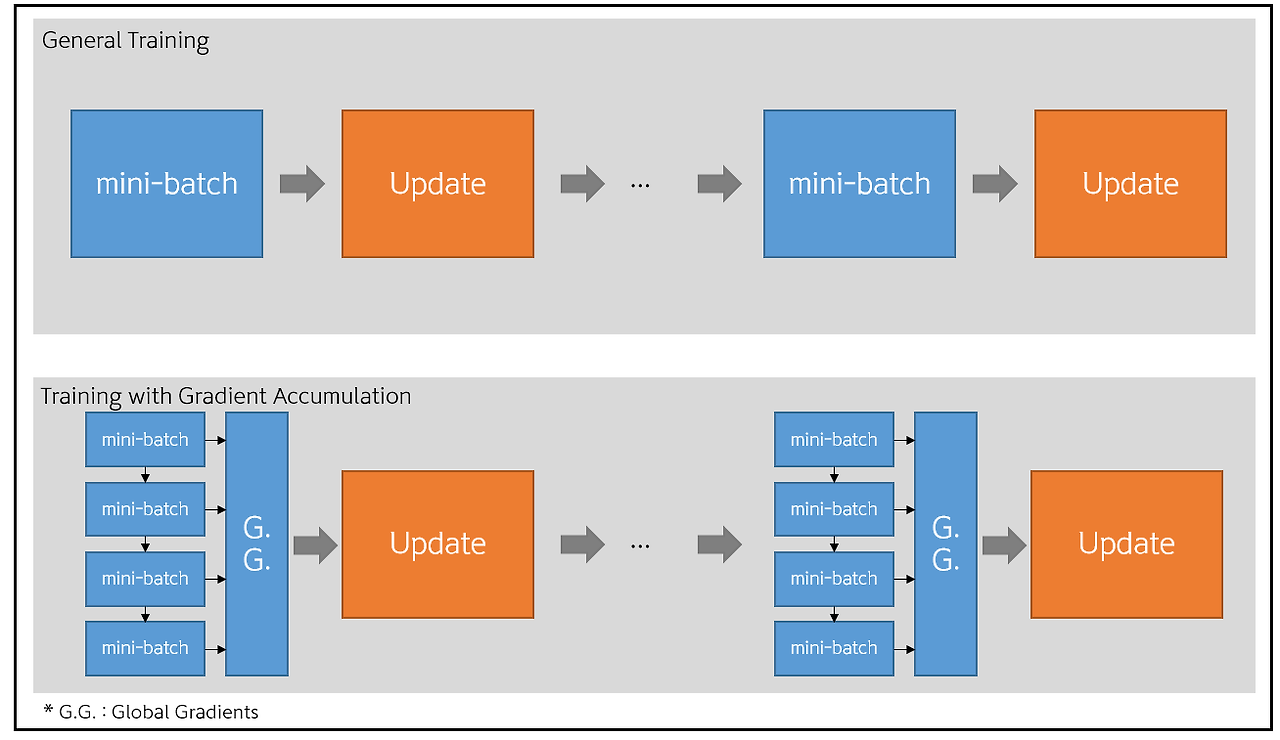

아래의 간단한 코드로 모델 훈련을 시작하겠습니다.

In [ ]:
trainer.train()

* 적절한 태그와 README 정보를 사용하여 허브에서 모델에 더 쉽게 액세스할 수 있도록 할 수 있습니다.

* Able은 데이터 세트, 언어 및 모델 이름과 일치하도록 이러한 값을 변경할 수 있습니다.

In [ ]:
kwargs = {
    "dataset_tags": "mozilla-foundation/common_voice_12_0",  # 데이터셋을 식별하는 데 사용되는 태그. 이 태그를 통해 데이터셋을 쉽게 찾고 참조할 수 있습니다.
    "dataset": "Common Voice 12.0",  # 학습 데이터셋에 대한 이름. 이 이름은 모델 학습 및 평가 과정에서 데이터셋을 쉽게 식별할 수 있도록 합니다.
    "dataset_args": "config: ko, split: test",  # 데이터셋에 대한 추가적인 인수 (예: 언어 설정, 분할 등)
    "language": "ko",  # 모델이 처리하는 언어
    "model_name": "Whisper Small Youngsik Moon",  # 모델 이름. 모델을 쉽게 식별하고 관리할 수 있도록 합니다.
    "finetuned_from": "openai/whisper-small",  # 사전 훈련된 모델로부터 파인튜닝된 경우, 원본 모델의 이름 또는 태그
    "tasks": "automatic-speech-recognition",  # 모델이 수행하는 작업 또는 태스크 . 이 정보는 모델의 기능과 적용 분야를 나타냅니다.
}
# 이러한 매개변수들은 모델 학습, 평가 및 배포 과정에서 중요한 역할을 합니다.

이제 훈련 결과가 허브에 업로드됩니다.
* `push_to_hub` 명령을 실행하고 우리가 만든 전처리기 개체를 저장합니다.

In [ ]:
# 학습된 모델을 Hugging Face Hub에 업로드하는 코드
# push_to_hub 함수는 모델을 Hugging Face Hub에 업로드하는 데 사용됩니다.
# **kwargs는 키워드 인수를 딕셔너리로 전달하는 Python의 특별한 구문입니다.
# 이를 통해 모델의 메타데이터와 관련된 정보(dataset_tags, dataset, dataset_args, language, model_name, finetuned_from, tasks 등)를 전달할 수 있습니다.
# 이 정보는 모델을 식별하고 설명하는 데 사용됩니다.
# 따라서, 이 코드는 학습된 모델을 Hugging Face Hub에 업로드하여 다른 사용자들이 모델을 찾고 사용할 수 있도록 하는 데 사용됩니다.
trainer.push_to_hub(**kwargs)

## 데모 구축

모델을 미세 조정한 후 데모를 구축하여 ASR 기능을 보여주세요!

* 🤗 트랜스포머를 활용해보세요
'파이프라인'
    * 오디오 입력 전처리부터 모델 예측 디코딩까지 전체 ASR 파이프라인을 관리합니다.

* 아래 예제 실행
    * Gradio 데모를 생성합니다.
     컴퓨터의 마이크를 통해 음성을 녹음하고 이를 미세 조정된 Whisper 모델에 입력하여 해당 텍스트를 기록할 수 있습니다.

In [ ]:
!pip install gradio
#  Gradio는 기계 학습 모델을 사용자 친화적인 웹 인터페이스로 쉽게 구현할 수 있는 Python 라이브러리입니다.

In [ ]:
# Hugging Face Transformers 라이브러리에서 pipeline 모듈을 가져옵니다.
# Transformers 라이브러리는 다양한 자연어 처리 모델을 제공하며, pipeline 모듈은 이러한 모델을 쉽게 사용할 수 있도록 도와줍니다.
# 이 모듈을 통해 음성 인식, 텍스트 생성, 감정 분석 등 다양한 자연어 처리 작업을 수행할 수 있습니다.
from transformers import pipeline

# Gradio 라이브러리를 가져옵니다.
# Gradio는 간단한 웹 인터페이스를 통해 모델을 시각화하고 상호작용할 수 있도록 도와줍니다.
# 이를 통해 사용자는 모델의 입력과 출력을 쉽게 확인하고 테스트할 수 있습니다.
import gradio as gr

# Transformers 라이브러리의 pipeline 함수를 사용하여 음성 인식 모델을 로드합니다.
# 이 경우 "ZeroWater93/whisper-small-ko" 모델을 사용합니다.
# 이 모델은 한국어 음성을 인식하는 데 특화된 모델입니다.
# 사용자가 선택한 다른 모델로 변경할 수도 있습니다.
pipe = pipeline(model="youngsik/whisper-small-ko")

# 사용자가 입력한 오디오 파일을 받아 음성 인식을 수행하는 함수를 정의합니다.
def transcribe(audio):
    # 로드된 음성 인식 모델을 사용하여 오디오 파일을 텍스트로 변환합니다.
    # 모델의 출력 결과에서 "text" 필드를 추출합니다.
    # 이 과정에서 모델은 오디오 파일의 내용을 분석하여 해당 내용을 텍스트로 변환합니다.
    text = pipe(audio)["text"]
    # 변환된 텍스트를 반환합니다.
    return text


In [ ]:
iface = gr.Interface(# Gradio 라이브러리를 사용하여 웹 인터페이스를 생성합니다.
    fn=transcribe,# 함수를 사용하여 음성 인식을 수행합니다.
    inputs=gr.Audio(source="file", type="filepath"),# 사용자는 파일을 통해 오디오를 입력할 수 있으며, 입력된 오디오 파일의 유형은 파일 경로입니다.
    outputs="text", # 모델의 출력은 텍스트로 제공됩니다.
    title="Whisper Small Korean",#웹 인터페이스의 제목을 설정합니다.
    description="Realtime demo for Korean speech recognition using a fine-tuned Whisper small model.", #웹 인터페이스의 설명을 설정합니다.
)

# 생성된 웹 인터페이스를 실행합니다.
iface.launch()

# 이 코드는 마이크를 통해 실시간으로 음성을 입력하는 것과 달리, 사용자가 녹음한 파일을 입력하여 음성 인식을 수행할 수 있도록 합니다.
# 주요 차이점은 다음과 같습니다:
# inputs=gr.Audio(source="file", type="filepath"): 사용자가 파일을 통해 오디오를 입력할 수 있도록 설정합니다.
# 입력된 오디오 파일의 유형은 파일 경로입니다.
# 나머지 부분은 마이크를 통한 실시간 입력과 동일합니다.
# 즉, fn=transcribe를 통해 음성 인식을 수행하고, outputs="text"를 통해 텍스트 출력을 제공합니다.
# 이와 같이 사용자가 녹음한 파일을 입력하여 음성 인식을 수행할 수 있도록 Gradio 인터페이스를 구현하였습니다.


In [ ]:
# Gradio 라이브러리를 사용하여 웹 인터페이스를 생성합니다.
iface = gr.Interface(
    fn=transcribe,#transcribe 함수를 사용하여
    inputs=gr.File(type="filepath", label="Upload Audio File"),#사용자는 파일을 업로드하여 오디오를 입력할 수 있으며, 입력된 오디오 파일의 유형은 파일 경로입니다. 또한, "Upload Audio File"이라는 레이블을 가진 파일 입력란을 생성합니다.
    outputs="text", #모델의 출력은 텍스트로 제공됩니다.
    title="Whisper Small Korea",# 웹 인터페이스의 제목을 설정합니다.
    description="Realtime demo for Korea speech recognition using a fine-tuned Whisper small model.",# 웹 인터페이스의 설명을 설정합니다.
)

# 생성된 웹 인터페이스를 실행합니다.
iface.launch()

# 이 코드는 사용자가 파일을 업로드하여 음성을 입력하고, 해당 음성에 대한 인식 결과를 텍스트로 제공하는 Gradio 인터페이스를 생성합니다.

# 주요 특징은 다음과 같습니다:
# inputs=gr.File(type="filepath", label="Upload Audio File"): 사용자가 파일을 업로드할 수 있는 입력란을 생성합니다. 입력된 오디오 파일의 유형은 파일 경로이며, 입력란의 레이블은 "Upload Audio File"입니다.
# outputs="text": 모델의 출력은 텍스트로 제공됩니다.
# title="Whisper Small Korea": 웹 인터페이스의 제목을 "Whisper Small Korea"로 설정합니다.
# description="Realtime demo for Korea speech recognition using a fine-tuned Whisper small model.": 웹 인터페이스의 설명을 설정합니다.
# 이와 같이 Gradio를 사용하여 파일 업로드를 통한 음성 입력 및 인식 결과 제공을 구현한 웹 인터페이스를 실행합니다.

# Faster WhisperAI fine-tuning 하는 코드 (한국어.ver)

https://github.com/Vaibhavs10/fast-whisper-finetuning/blob/main/Whisper_w_PEFT.ipynb

Whisper 모델을 더 빠르고 효율적으로 사용하기 위한 기법.


---






Quantization (양자화)
* 정의: 양자화는 모델의 가중치와 활성화 함수 값을 낮은 비트 수로 표현하는 기술입니다.
* 목적: 모델 크기를 줄이고 추론 속도를 높이는 것이 목적입니다.
* 장점:
 * 모델 크기 감소: 낮은 비트 수로 표현하면 모델 크기가 줄어듭니다.
 * 추론 속도 향상: 낮은 비트 수 연산이 빠르기 때문에 추론 속도가 빨라집니다.
* 종류:
정적 양자화: 모델 학습 후 가중치를 양자화하는 방식
* 동적 양자화: 추론 시 입력 데이터에 따라 동적으로 양자화하는 방식

---

LoRA (Low Rank Adaptation)
* LoRA는 모델의 전체 파라미터를 fine-tuning하는 대신, 일부 파라미터만 업데이트하는 기법입니다.
* 이를 통해 모델 크기를 크게 줄이면서도 성능 저하를 최소화할 수 있습니다.
* LoRA는 GPT-3 175B 모델 대비 약 10,000배 적은 파라미터로 fine-tuning이 가능하다고 합니다.

---



Parameter Efficient Fine-Tuning (PEFT)
* 정의: PEFT는 모델의 일부 파라미터만 fine-tuning하는 기법입니다.
* 목적: 적은 수의 파라미터만 fine-tuning하여 모델 성능을 유지하면서도 메모리와 계산 비용을 줄이는 것이 목적입니다.
* 장점:
적은 수의 파라미터 fine-tuning: 전체 모델을 fine-tuning하는 것보다 적은 수의 파라미터만 fine-tuning합니다.
* 메모리 및 계산 비용 감소: 적은 수의 파라미터만 fine-tuning하므로 메모리와 계산 비용이 줄어듭니다.
* 기법:
Prompt Tuning
LoRA (Low-Rank Adaptation)
Prefix Tuning
Adapter Tuning

---



## LoRA (Low Rank Adaptation) 와 PEFT (Paramater Efficient Fine Tuning)를 적용한 Whisper fine-tuning

Whisper 모델에 LoRA와 PEFT를 적용하면 다음과 같은 장점을 얻을 수 있습니다:
* 모델 크기 감소: LoRA와 PEFT를 통해 Whisper 모델의 크기를 크게 줄일 수 있습니다.
* 추론 속도 향상: 모델 크기 감소로 인해 추론 속도가 빨라집니다.
* 메모리 및 계산 비용 감소: 일부 파라미터만 fine-tuning하므로 메모리와 계산 비용이 줄어듭니다.
* 성능 유지: LoRA와 PEFT를 통해 Whisper 모델의 성능을 유지하면서도 효율성을 높일 수 있습니다.

종합하면, LoRA와 PEFT는 대규모 언어 모델을 효율적으로 fine-tuning할 수 있는 기법입니다.
Whisper 모델에 이 기법들을 적용하면 모델 크기 감소, 추론 속도 향상, 메모리 및 계산 비용 감소 등의 장점을 얻을 수 있습니다.
이를 통해 Whisper 모델의 활용도를 높일 수 있습니다.

---








* 소비자 GPU의 VRAM이 8GB 미만인 환경에서도 full-finetuning과 유사한 성능을 제공함
*  🤗 Transformers and PEFT 모델과 Common Voice 13.0 dataset를 사용하여 Whisper fine-tune하는 과정 설명함
* PEFT와 bitsandbytes를 활용하여 무료 T4 GPU(16GB VRAM)를 사용하여 whisper-large-v2 체크포인트를 원활하게 학습

---



### 왜 Parameter Efficient Fine Tuning [PEFT](https://github.com/huggingface/peft)를 사용해야 되는가?


* PEFT
    * 효과적으로 parameter를 줄여서 fine tuning 속도 개선
    * 목적: 병목 현상을 해결
    * 접근법(예: 저수준 적응): 사전 훈련된 모델의 대부분의 매개변수를 동결시키면서 추가 모델 매개변수의 일부만 미세 조정하여 계산 및 저장 비용 크게 줄임
        * 대규모 모델의 전체 미세 조정 중 관찰되는 catastrophic forgetting 문제를 극복할 수 있음


---



* 모델 사이즈 증가로 fine tuning하는 것이 계산 복잡성 증가와 메모리 사용량 증가
    * 예를 들어, Whisper-large-v2 모델을 완전한 미세 조정을 위해 약 24GB의 GPU VRAM이 필요하며, 각 미세 조정된 모델은 약 7GB의 저장 공간을 필요함

    * 제한적인 환경에서 bottleneck 발생하고 원하는 결과를 얻기 힘듦



---



#### LoRA가 무엇인가?

* PEFT에서 여러 매개변수 효율적인 기술을 기본으로 제공
    * 그 중 하나인 Low Rank Adaptation (LoRA)
        * 사전 훈련된 모델 가중치를 동결하고 Transformer 아키텍처의 각 레이어에 훈련 가능한 랭크 분해 행렬을 삽입 (High Rank 즉 많은 연결이 되어 있는 것들보다 연결이 적은 Low Rank로 만들어서 계산량을 줄임)
            * Downstream 작업에 대한 훈련 가능한 매개변수 수가 크게 감소

---



#### 통계로 보는 PEFT 효과


* Full fine-tuning of Whisper-large-v2 checkpoint Vs. PEFT 적용 모델

    1. GPU VRAM이 8GB 미만인 환경에서 16억 개의 매개변수를 가진 모델을 미세 조정 🤯
    2. 훨씬 적은 수의 훈련 가능한 매개변수를 사용하여 거의 5배 더 큰 배치 크기를 사용 가능 📈
    3. 생성된 체크포인트는 원본 모델의 크기의 1%인 약 60MB 🚀

* 기존 🤗 transformers Whisper에서 변형이 많이 되지 않았음


---


    



### 환경설정

우리는 Whisper 모델을 미세 조정하기 위해 몇 가지 인기 있는 Python 패키지를 사용할 것입니다.

데이터 세트를 사용하여 훈련 데이터를 다운로드하고 준비하며 변환기를 사용하여 Whisper 모델을 로드하고 훈련할 것입니다.

또한 오디오 파일을 전처리하고 모델 성능을 평가하기 위해 librosa 패키지가 필요합니다.

마지막으로 PEFT, 비트앤바이트, 가속을 사용하여 LoRA로 모델을 준비하고 미세 조정합니다.

In [ ]:
# 필요한 라이브러리 설치
!pip install -q transformers datasets librosa evaluate jiwer gradio bitsandbytes==0.37 accelerate
# transformers: 허깅페이스의 언어 모델 라이브러리
# datasets: 허깅페이스의 데이터셋 라이브러리
# librosa: 오디오 처리 라이브러리
# evaluate: 모델 평가 도구
# jiwer: 음성 인식 성능 평가 지표
# gradio: 웹 기반 UI 라이브러리
# bitsandbytes==0.37: 비트 연산 가속화 라이브러리, 버전 0.37 사용
# accelerate: 모델 학습 가속화 라이브러리

# PEFT 라이브러리 설치
!pip install -q git+https://github.com/huggingface/peft.git@main
# peft: 허깅페이스에서 개발한 Parameter Efficient Fine-Tuning 라이브러리
# 이 라이브러리를 통해 모델의 일부 파라미터만 fine-tuning할 수 있어 메모리와 계산 비용을 줄일 수 있습니다.

# 이렇게 필요한 라이브러리들을 설치하면 LoRA와 PEFT를 사용하여 Whisper 모델을 효율적으로 fine-tuning할 수 있습니다.
# 이를 통해 모델 크기를 줄이고, 추론 속도를 높이며, 메모리와 계산 비용을 절감할 수 있습니다.

이제 환경이 설정되었으므로 Colab에 적합한 GPU를 확보해 보겠습니다!

안타깝게도 Google Colab 무료 버전으로 좋은 GPU에 액세스하는 것이 훨씬 더 어려워지고 있습니다.

그러나 Google Colab Pro를 사용하면 V100 또는 P100 GPU를 할당하는 데 문제가 없습니다.

GPU를 얻으려면 런타임 -> 런타임 유형 변경을 클릭한 다음 하드웨어 가속기를 없음에서 GPU로 변경하세요.

GPU가 할당되었는지 확인하고 해당 사양을 볼 수 있습니다.

In [ ]:
# NVIDIA GPU 정보를 확인하는 명령어 실행
gpu_info = !nvidia-smi

# 명령어 실행 결과를 문자열로 변환
gpu_info = '\n'.join(gpu_info)

# GPU 정보에 'failed'가 포함되어 있는지 확인
if gpu_info.find('failed') >= 0:
  # GPU에 연결되어 있지 않은 경우 출력
  print('Not connected to a GPU')
else:
  # GPU 정보 출력
  print(gpu_info)


# !nvidia-smi 명령어를 실행하여 NVIDIA GPU 정보를 확인합니다.
# 이 명령어는 GPU 드라이버 버전, CUDA 버전, GPU 온도, 팬 속도 등 다양한 정보를 제공합니다.
# gpu_info = '\n'.join(gpu_info) 코드를 통해 명령어 실행 결과를 문자열로 변환합니다.
# if gpu_info.find('failed') >= 0: 코드에서는 GPU 정보 문자열에 'failed'가 포함되어 있는지 확인합니다. 이는 GPU에 연결되어 있지 않은 경우 발생할 수 있습니다.
# 'failed'가 포함되어 있는 경우 "Not connected to a GPU"라는 메시지를 출력합니다.
# 'failed'가 포함되어 있지 않은 경우 GPU 정보를 출력합니다.

# 이 코드를 통해 사용자는 자신의 시스템에 NVIDIA GPU가 연결되어 있는지, 그리고 GPU 정보를 확인할 수 있습니다.
# 이는 딥러닝 모델 학습 및 추론 시 GPU 활용을 위해 필수적인 정보입니다.

Colab에서 제공한 GPU를 사용하도록 환경을 구성해 보겠습니다.

In [ ]:
import os

# CUDA_VISIBLE_DEVICES 환경 변수를 "0"으로 설정
# 이는 CUDA를 사용하는 프로그램이 첫 번째 GPU(일반적으로 0부터 시작)만 사용하도록 지정하는 것입니다.
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


# import os를 통해 운영 체제와 상호 작용하기 위한 os 모듈을 가져옵니다.
# os.environ["CUDA_VISIBLE_DEVICES"] = "0" 코드를 통해 CUDA_VISIBLE_DEVICES 환경 변수를 0으로 설정합니다.
# 이는 CUDA를 사용하는 프로그램이 첫 번째 GPU(일반적으로 0부터 시작)만 사용하도록 지정하는 것입니다.

# 이 코드를 통해 사용자는 CUDA를 사용하는 프로그램이 특정 GPU만을 활용하도록 설정할 수 있습니다.
# GPU가 여러 개인 경우, 이러한 설정을 통해 각 프로그램이 특정 GPU를 사용하도록 제어할 수 있습니다.

[Hugging Face Hub](https://huggingface.co/)에 모델 체크포인트를 직접 업로드하는 것이 좋습니다.
훈련하는 동안. 허브는 다음을 제공합니다.
- 통합 버전 제어: 학습 중에 모델 체크포인트가 손실되지 않도록 할 수 있습니다.
- Tensorboard 로그: 훈련 과정에서 중요한 측정항목을 추적합니다.
- 모델 카드: 모델이 수행하는 작업과 의도된 사용 사례를 문서화합니다.
- 커뮤니티: 커뮤니티와 쉽게 공유하고 협업할 수 있는 방법입니다!

노트북을 허브에 연결하는 것은 간단합니다.

메시지가 표시되면 허브 인증 토큰을 입력하기만 하면 됩니다.

Hub 인증 토큰을 [여기](https://huggingface.co/settings/tokens)에서 찾으세요.

In [ ]:
# huggingface_hub 라이브러리에서 notebook_login 함수를 가져옵니다.
from huggingface_hub import notebook_login

# notebook_login() 함수를 호출하여 Hugging Face Hub에 로그인합니다.
# 이 함수는 로그인 토큰을 입력하는 팝업 창을 띄워줍니다.
notebook_login()

# from huggingface_hub import notebook_login을 통해 Hugging Face Hub 라이브러리에서 notebook_login 함수를 가져옵니다.
# notebook_login() 함수를 호출하면 Hugging Face Hub에 로그인할 수 있습니다.
# 이 함수는 로그인 토큰을 입력하는 팝업 창을 띄워줍니다.

# 이 코드를 실행하면 Hugging Face Hub에 로그인할 수 있습니다.
# 로그인 토큰을 직접 입력하는 방법 외에도 huggingface_hub 라이브러리를 사용하여 로그인할 수 있습니다.
# 이를 통해 Hugging Face Hub의 다양한 기능을 사용할 수 있습니다.

다음으로 Whisper 모델 체크포인트와 작업 세부정보를 정의합니다.

In [ ]:
# Whisper 모델의 이름 또는 경로를 지정합니다.
model_name_or_path = "openai/whisper-large-v2"

# 수행할 작업을 "transcribe"로 설정합니다.
# 이는 오디오 파일을 텍스트로 전사하는 작업을 의미합니다.
task = "transcribe"


# model_name_or_path = "openai/whisper-large-v2"에서는 사용할 Whisper 모델의 이름 또는 경로를 지정합니다.
# 이 경우 "openai/whisper-large-v2" 모델을 사용합니다.
# task = "transcribe"에서는 수행할 작업을 "transcribe"로 설정합니다.
# 이는 오디오 파일을 텍스트로 전사하는 작업을 의미합니다.

# 이 코드는 Whisper 모델을 사용하여 오디오 파일을 텍스트로 전사하는 작업을 수행할 수 있도록 설정합니다.
#  이를 통해 음성 인식 및 자동 전사 기능을 구현할 수 있습니다.

마지막으로 Whisper를 미세 조정하려는 언어를 포함하여 데이터 세트 세부 사항을 정의합니다.

In [ ]:
# Common Voice 데이터셋의 이름을 지정합니다.
dataset_name = "mozilla-foundation/common_voice_13_0"

# 사용할 언어를 한국어로 설정합니다.
language = "korean"

# 한국어의 ISO 639-1 언어 코드인 "ko"를 사용합니다.
language_abbr = "ko" # Short hand code for the language we want to fine-tune


# dataset_name = "mozilla-foundation/common_voice_13_0"에서는 사용할 Common Voice 데이터셋의 이름을 지정합니다.
# 이 경우 "mozilla-foundation/common_voice_13_0" 데이터셋을 사용합니다.
# language = "korean"에서는 사용할 언어를 한국어로 설정합니다.
# language_abbr = "ko"에서는 한국어의 ISO 639-1 언어 코드인 "ko"를 사용합니다.
# 이는 데이터셋에서 한국어 데이터를 선택하는 데 사용됩니다.

### 데이터셋 로드


🤗 데이터 세트를 사용하면 데이터를 다운로드하고 준비하는 것이 매우 간단합니다.

단 한 줄의 코드로 Common Voice 스플릿을 다운로드하고 준비할 수 있습니다.

먼저 Hugging Face Hub(mozilla-foundation/common_voice_13_0)의 사용 약관에 동의했는지 확인하세요.

약관에 동의하면 데이터 세트에 대한 전체 액세스 권한을 갖고 데이터를 로컬로 다운로드할 수 있습니다.

In [ ]:
from datasets import load_dataset, DatasetDict

# Common Voice 데이터셋을 로드하기 위한 DatasetDict 객체를 생성합니다.
common_voice = DatasetDict()

# load_dataset() 함수를 사용하여 Common Voice 데이터셋의 "train+validation" 데이터를 로드합니다.
# 이때 language_abbr 변수를 사용하여 한국어 데이터를 선택합니다.
# use_auth_token=True를 설정하여 Hugging Face API 토큰을 사용합니다.
common_voice["train"] = load_dataset(dataset_name, language_abbr, split="train+validation", use_auth_token=True)

# load_dataset() 함수를 사용하여 Common Voice 데이터셋의 "test" 데이터를 로드합니다.
# 이때 language_abbr 변수를 사용하여 한국어 데이터를 선택합니다.
# use_auth_token=True를 설정하여 Hugging Face API 토큰을 사용합니다.
common_voice["test"] = load_dataset(dataset_name, language_abbr, split="test", use_auth_token=True)

# 로드된 데이터셋을 출력합니다.
print(common_voice)



# from datasets import load_dataset, DatasetDict에서는 Common Voice 데이터셋을 로드하기 위해 필요한 함수와 클래스를 가져옵니다.
# common_voice = DatasetDict()에서는 Common Voice 데이터셋을 저장할 DatasetDict 객체를 생성합니다.
# common_voice["train"] = load_dataset(dataset_name, language_abbr, split="train+validation", use_auth_token=True)에서는 load_dataset() 함수를 사용하여 Common Voice 데이터셋의 "train+validation" 데이터를 로드합니다.
# language_abbr 변수를 사용하여 한국어 데이터를 선택하며, use_auth_token=True를 설정하여 Hugging Face API 토큰을 사용합니다.
# common_voice["test"] = load_dataset(dataset_name, language_abbr, split="test", use_auth_token=True)에서는 load_dataset() 함수를 사용하여 Common Voice 데이터셋의 "test" 데이터를 로드합니다.
# 마찬가지로 language_abbr 변수를 사용하여 한국어 데이터를 선택하며, use_auth_token=True를 설정하여 Hugging Face API 토큰을 사용합니다.
# print(common_voice)에서는 로드된 데이터셋을 출력합니다.

# 이 코드를 통해 Common Voice 데이터셋의 한국어 데이터를 "train+validation"과 "test" 데이터로 분리하여 로드할 수 있습니다.
#  이후 이 데이터를 사용하여 한국어 음성 인식 모델을 fine-tuning할 수 있습니다.


* 일반적인 ASR(음성 인식) 데이터셋
    * 입력 오디오 샘플(오디오)과 해당되는 텍스트(문장)만 제공
* Common Voice
    * ASR에는 필요하지 않은 악센트와 로케일과 같은 추가 메타데이터 정보가 포함
    * 일반적인 용도로 사용하고 미세 조정을 고려하기 위해 메타데이터 정보 무시

In [ ]:
common_voice = common_voice.remove_columns( #필요 없는 컬럼 제거
    ["accent", "age", "client_id", "down_votes", "gender", "locale", "path", "segment", "up_votes", "variant"]
)

print(common_voice)

#### 특성 추출기(Feature Extractor), 토크나이저(Tokenizer), 그리고 데이터준비



ASR 파이프라인은 세 단계로 분해될 수 있습니다.

1. 원시 오디오 입력을 전처리하는 특징 추출기
2. 시퀀스 간 매핑을 수행하는 모델
3. 모델 출력을 텍스트 형식으로 후처리하는 토크나이저


* Whisper
    * [WhisperFeatureExtractor](https://huggingface.co/docs/transformers/main/model_doc/whisper#transformers.WhisperFeatureExtractor)와 [WhisperTokenizer](https://huggingface.co/docs/transformers/main/model_doc/whisper#transformers.WhisperTokenizer)로 구성



In [ ]:
from transformers import WhisperFeatureExtractor
# WhisperFeatureExtractor 클래스를 사용하여 Whisper 모델에 필요한 feature extractor를 로드합니다.
# from_pretrained() 메서드를 사용하여 사전 학습된 feature extractor를 가져옵니다.
# 이때 model_name_or_path 변수에는 Whisper 모델의 이름 또는 경로를 지정합니다.
feature_extractor = WhisperFeatureExtractor.from_pretrained(model_name_or_path)


# from transformers import WhisperFeatureExtractor에서는 Whisper 모델에 필요한 feature extractor를 가져옵니다.
# feature_extractor = WhisperFeatureExtractor.from_pretrained(model_name_or_path)에서는 WhisperFeatureExtractor 클래스의 from_pretrained() 메서드를 사용하여 사전 학습된 feature extractor를 로드합니다.
# model_name_or_path 변수에는 Whisper 모델의 이름 또는 경로를 지정합니다.

# 이 코드를 통해 Whisper 모델을 사용하기 위해 필요한 feature extractor를 로드할 수 있습니다.
# 이후 이 feature extractor를 사용하여 음성 데이터를 Whisper 모델의 입력 형식으로 변환할 수 있습니다.

In [ ]:
from transformers import WhisperTokenizer
# WhisperTokenizer 클래스를 사용하여 Whisper 모델에 필요한 tokenizer를 로드합니다.
# from_pretrained() 메서드를 사용하여 사전 학습된 tokenizer를 가져옵니다.
# 이때 model_name_or_path 변수에는 Whisper 모델의 이름 또는 경로를 지정합니다.
# language 변수에는 사용할 언어를 지정하고, task 변수에는 수행할 작업(예: 음성 인식, 텍스트 생성 등)을 지정합니다.
tokenizer = WhisperTokenizer.from_pretrained(model_name_or_path, language=language, task=task)


# from transformers import WhisperTokenizer에서는 Whisper 모델에 필요한 tokenizer를 가져옵니다.
# tokenizer = WhisperTokenizer.from_pretrained(model_name_or_path, language=language, task=task)에서는 WhisperTokenizer 클래스의 from_pretrained() 메서드를 사용하여 사전 학습된 tokenizer를 로드합니다.
#  model_name_or_path 변수에는 Whisper 모델의 이름 또는 경로를 지정하고, language 변수에는 사용할 언어를, task 변수에는 수행할 작업(예: 음성 인식, 텍스트 생성 등)을 지정합니다.


# 이 코드를 통해 Whisper 모델을 사용하기 위해 필요한 tokenizer를 로드할 수 있습니다.
#  이후 이 tokenizer를 사용하여 입력 데이터를 Whisper 모델의 형식으로 변환할 수 있습니다.

기능 추출기와 토크나이저 사용을 단순화하기 위해 두 가지를 하나의 `WhisperProcessor` 클래스로 _wrap_할 수 있습니다.

 이 프로세서 객체는 필요에 따라 오디오 입력 및 모델 예측에 사용될 수 있습니다.

그렇게 하면 훈련 중에 두 가지 객체만 추적하면 됩니다.

'프로세서' 및 '모델':

In [ ]:
from transformers import WhisperProcessor
# WhisperProcessor 클래스를 사용하여 Whisper 모델에 필요한 processor를 로드합니다.
# from_pretrained() 메서드를 사용하여 사전 학습된 processor를 가져옵니다.
# 이때 model_name_or_path 변수에는 Whisper 모델의 이름 또는 경로를 지정합니다.
# language 변수에는 사용할 언어를 지정하고, task 변수에는 수행할 작업(예: 음성 인식, 텍스트 생성 등)을 지정합니다.
processor = WhisperProcessor.from_pretrained(model_name_or_path, language=language, task=task)


# from transformers import WhisperProcessor에서는 Whisper 모델에 필요한 processor를 가져옵니다.
# processor = WhisperProcessor.from_pretrained(model_name_or_path, language=language, task=task)에서는 WhisperProcessor 클래스의 from_pretrained() 메서드를 사용하여 사전 학습된 processor를 로드합니다.
# model_name_or_path 변수에는 Whisper 모델의 이름 또는 경로를 지정하고, language 변수에는 사용할 언어를, task 변수에는 수행할 작업(예: 음성 인식, 텍스트 생성 등)을 지정합니다.


# 이 코드를 통해 Whisper 모델을 사용하기 위해 필요한 processor를 로드할 수 있습니다.
# 이후 이 processor를 사용하여 입력 데이터를 Whisper 모델의 형식으로 변환할 수 있습니다.

##### 데이터 준비


Common Voice 데이터셋의 첫 번째 예제를 출력하여 데이터의 형식을 살펴봄

In [ ]:
print(common_voice["train"][0])

* Whisper 모델 샘플링
    * 입력 오디오는 48 kHz 새플링
    * Whisper feature extractor에 전달하기 위해서 16 kHz로 다운샘플 진행
* 샘플링 속도 설정
    * Dataset의 [`cast_column`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=cast_column#datasets.DatasetDict.cast_column) 방법 사용: 오디오 입력을 올바른 샘플링 속도로 설정
    * 오디오를 변경하는 것이 아니라 오디오 샘플을 실시간으로 받을 수 있도록 함


In [ ]:
from datasets import Audio

# common_voice 데이터셋의 "audio" 열을 Audio 객체로 변환합니다.
# Audio 객체는 오디오 데이터를 처리하는 데 필요한 정보를 포함하고 있습니다.
# sampling_rate=16000 옵션을 통해 오디오 데이터의 샘플링 레이트를 16kHz로 설정합니다.
# 이는 일반적인 음성 처리 작업에 적합한 샘플링 레이트입니다.
common_voice = common_voice.cast_column("audio", Audio(sampling_rate=16000))


# from datasets import Audio에서는 오디오 데이터를 처리하는 데 필요한 Audio 클래스를 가져옵니다.
# common_voice = common_voice.cast_column("audio", Audio(sampling_rate=16000))에서는 common_voice 데이터셋의 "audio" 열을 Audio 객체로 변환합니다. sampling_rate=16000 옵션을 통해 오디오 데이터의 샘플링 레이트를 16kHz로 설정합니다.
# 이는 일반적인 음성 처리 작업에 적합한 샘플링 레이트입니다.


# 이 코드를 통해 common_voice 데이터셋의 오디오 데이터를 처리할 수 있습니다.
# 이후 이 데이터를 사용하여 음성 인식, 음성 합성 등의 작업을 수행할 수 있습니다.
# 또한 사용자 정의 오디오 데이터셋을 생성하고 공유할 수 있는 기능도 제공합니다.
# 이를 통해 음성 처리 모델 개발에 필요한 데이터를 쉽게 확보할 수 있습니다.

Common Voice 데이터세트의 첫 번째 오디오 샘플을 다시 로드하면 리샘플링됩니다.
원하는 샘플링 속도로 설정합니다.

In [ ]:
print(common_voice["train"][0])

이제 모델에 사용할 데이터를 준비하는 함수를 작성할 수 있습니다.
1. `batch["audio"]`를 호출하여 오디오 데이터를 로드하고 리샘플링합니다. 위에서 설명한 대로 🤗 데이터세트는 필요한 모든 리샘플링 작업을 즉시 수행합니다.
2. 특징 추출기를 사용하여 1차원 오디오 배열에서 log-Mel 스펙트로그램 입력 특징을 계산합니다.
3. 토크나이저를 사용하여 텍스트를 라벨 ID로 인코딩합니다.

In [ ]:
def prepare_dataset(batch):
    # 1. 오디오 데이터 로드 및 16kHz로 리샘플링
    audio = batch["audio"]

    # 2. 입력 오디오 배열에서 로그-멜 스펙트로그램 특징 추출
    # feature_extractor는 오디오 특징 추출기 모델
    # input_features는 추출된 특징 벡터
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # 3. 타겟 문장을 토크나이저를 사용하여 라벨 ID로 인코딩
    # tokenizer는 텍스트를 토큰화하고 ID로 변환하는 모델
    batch["labels"] = tokenizer(batch["sentence"]).input_ids

    # 4. 준비된 데이터를 반환
    return batch


# audio = batch["audio"]에서는 입력 데이터셋의 "audio" 필드에서 오디오 데이터를 가져옵니다.
# batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]에서는 입력 오디오 배열에서 로그-멜 스펙트로그램 특징을 추출합니다. feature_extractor는 오디오 특징 추출기 모델이며, 추출된 특징 벡터는 input_features에 저장됩니다.
# batch["labels"] = tokenizer(batch["sentence"]).input_ids에서는 타겟 문장을 토크나이저를 사용하여 라벨 ID로 인코딩합니다.
# tokenizer는 텍스트를 토큰화하고 ID로 변환하는 모델입니다.
# 준비된 데이터는 return batch를 통해 반환됩니다.
4

# 이 코드는 오디오 데이터와 텍스트 데이터를 처리하여 모델 학습에 사용할 수 있는 형태로 변환합니다.
# 오디오 데이터는 로그-멜 스펙트로그램 특징으로 변환되며, 텍스트 데이터는 토크나이저를 통해 라벨 ID로 인코딩됩니다.

데이터 세트의 `.map` 메소드를 사용하여 모든 훈련 예제에 데이터 준비 기능을 적용할 수 있습니다.

'num_proc' 인수는 사용할 CPU 코어 수를 지정합니다.

`num_proc` > 1로 설정하면 다중 처리가 활성화됩니다.

`.map` 메서드가 다중 처리로 인해 중단되면 `num_proc=1`을 설정하고 데이터세트를 순차적으로 처리합니다.

직접 만들어 보세요 🍵, 데이터세트 크기에 따라 20~30분 정도 걸릴 수 있습니다 ⏰

In [ ]:
# Common Voice 데이터셋을 처리하는 코드
common_voice = common_voice.map(
    # prepare_dataset 함수를 적용하여 데이터셋을 준비
    prepare_dataset,
    # 기존 "train" 데이터셋의 열을 제거
    remove_columns=common_voice.column_names["train"],
    # 2개의 프로세스를 사용하여 병렬 처리
    num_proc=2,
    # prepare_dataset 함수에 전달할 추가 인자
    fn_kwargs={
        "feature_extractor": feature_extractor,
        "tokenizer": tokenizer
    }
)


# common_voice = common_voice.map(...): Common Voice 데이터셋을 처리하는 코드입니다.
# prepare_dataset: 이전에 정의한 데이터셋 준비 함수를 적용합니다.
# remove_columns=common_voice.column_names["train"]: "train" 데이터셋의 열을 제거합니다. 이는 중복된 정보를 제거하기 위함입니다.
# num_proc=2: 2개의 프로세스를 사용하여 병렬 처리를 수행합니다. 이를 통해 처리 속도를 높일 수 있습니다.
# fn_kwargs={"feature_extractor": feature_extractor, "tokenizer": tokenizer}: prepare_dataset 함수에 전달할 추가 인자를 지정합니다. 여기서는 feature_extractor와 tokenizer를 전달합니다.


# 이 코드는 Common Voice 데이터셋을 처리하여 모델 학습에 사용할 수 있는 형태로 변환합니다.
#  데이터셋의 오디오 데이터는 로그-멜 스펙트로그램 특징으로 변환되며, 텍스트 데이터는 토크나이저를 통해 라벨 ID로 인코딩됩니다.
#  또한 병렬 처리를 통해 처리 속도를 높이고 있습니다.

In [ ]:
common_voice["train"]

#### 훈련 및 검증


훈련 파이프라인

* [🤗 Trainer](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer)가 대부분의 작업을 처리:


1. 데이터 collator 정의: 데이터 콜레이터는 우리가 전처리한 데이터를 가져와 모델에 사용할 수 있는 PyTorch 텐서로 준비
2. 평가 지표: 평가 중에는 모델을 글자 오류율  [word error rate (CER)](https://huggingface.co/metrics/cer)지표를 사용하여 평가
3. 사전 훈련된 체크포인트 load: 사전 훈련된 체크포인트를 로드하고 훈련을 위해 올바르게 구성
4. 훈련 구성 정의: 🤗 Trainer가 훈련 스케줄을 정의에 사용

* 미세 조정한 후에는 테스트 데이터에서 모델을 평가하여 한국어 음성을 올바르게 전사

##### Data Collator 정의


* 시퀀스-투-시퀀스 음성 모델의 데이터 콜레이터
    * Input_features와 labels를 독립적으로 처리
    
    - Input_features: feature extractor에 의해 처리
    - labels: tokenizer에 의해 처리

* Input_features는 이미 30초로 패딩되어 있고 특성 추출기에 의해 고정된 차원의 로그 멜 스펙트로그램으로 변환. 따라서 우리가 해야 할 일은 input_features를 배치 처리된 PyTorch 텐서로 변환

* labels는 패딩되지 않음 먼저 배치 내에서 최대 길이에 맞게 시퀀스를 패딩하고, tokenizer의 .pad 메서드를 사용하여 시퀀스를 패딩 패딩 토큰은 손실을 계산할 때 고려되지 않도록 -100으로 대체. 그런 다음 레이블 시퀀스의 시작에서 BOS 토큰을 잘라서 훈련 중에 나중에 이를 추가

* 이전에 정의한 WhisperProcessor를 활용하여 특성 추출기 및 토크나이저 작업을 모두 수행 가능

In [ ]:
import torch
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # 1. 입력 특징과 라벨 데이터를 분리
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        # 2. 입력 특징 배치 생성
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # 3. 라벨 데이터 배치 생성 및 패딩
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # 4. 패딩된 라벨에서 -100으로 마스킹하여 손실 계산 시 패딩 부분 무시
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # 5. 이전 토크나이징 과정에서 BOS 토큰이 추가된 경우 제거
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        # 6. 처리된 배치 데이터 반환
        batch["labels"] = labels
        return batch


# input_features = [{"input_features": feature["input_features"]} for feature in features]: 입력 특징과 라벨 데이터를 분리합니다.
# batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt"): 입력 특징 배치를 생성합니다. self.processor.feature_extractor.pad()는 입력 특징을 패딩하여 배치 형태로 변환합니다.
# labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt"): 라벨 데이터 배치를 생성합니다. self.processor.tokenizer.pad()는 라벨 데이터를 패딩하여 배치 형태로 변환합니다.
# labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100): 패딩된 라벨 데이터에서 -100으로 마스킹하여 손실 계산 시 패딩 부분을 무시합니다.
# if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item(): labels = labels[:, 1:]: 이전 토크나이징 과정에서 BOS(Begin Of Sequence) 토큰이 추가된 경우 제거합니다.
# batch["labels"] = labels; return batch: 처리된 배치 데이터를 반환합니다.


# 이 코드는 음성 인식 모델 학습을 위한 데이터 전처리 과정을 담당합니다.
# 입력 특징과 라벨 데이터를 분리하고, 각각 패딩하여 배치 형태로 변환합니다.
# 또한 라벨 데이터에서 패딩 부분을 -100으로 마스킹하여 손실 계산 시 이를 무시하도록 합니다.
# 마지막으로 BOS 토큰이 추가된 경우 제거하여 최종 배치 데이터를 반환합니다.

Data collator 초기화 진행

In [ ]:
# 1. DataCollatorSpeechSeq2SeqWithPadding 클래스 인스턴스 생성
# processor 매개변수에는 음성 데이터 전처리를 위한 Processor 객체가 전달됩니다.
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)


# data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor): DataCollatorSpeechSeq2SeqWithPadding 클래스의 인스턴스를 생성합니다.
#  이 클래스는 음성 데이터 전처리를 담당하며, processor 매개변수에는 음성 데이터 전처리를 위한 Processor 객체가 전달됩니다.


# 이 코드는 음성 인식 모델 학습을 위한 데이터 전처리 과정을 수행하는 부분입니다.
#  DataCollatorSpeechSeq2SeqWithPadding 클래스는 입력 특징과 라벨 데이터를 분리하고, 각각 패딩하여 배치 형태로 변환합니다.
#   또한 라벨 데이터에서 패딩 부분을 -100으로 마스킹하여 손실 계산 시 이를 무시하도록 합니다.
#  마지막으로 BOS 토큰이 추가된 경우 제거하여 최종 배치 데이터를 반환합니다.

##### 평가 지표


* ASR 시스템을 평가하기 위한 '사실상의' 지표인 한 단어 오류율(CER) 메트릭을 사용
* 더 많은 정보는 [문서](https://huggingface.co/metrics/cer)를 참조. 우리는 🤗 Evaluate에서 CER 메트릭을 로드

In [ ]:
# 1. evaluate 라이브러리 import
import evaluate

# 2. "cer" 메트릭 로드
metric = evaluate.load("cer")


# import evaluate: Hugging Face의 evaluate 라이브러리를 import합니다.
# 이 라이브러리는 다양한 자연어 처리 및 음성 처리 평가 메트릭을 제공합니다.
# metric = evaluate.load("cer"): evaluate.load("cer") 함수를 사용하여 Character Error Rate (CER) 메트릭을 로드합니다.
# CER은 자동 음성 인식 시스템을 평가하는 데 사용되는 일반적인 메트릭으로, Word Error Rate (WER)과 유사합니다.

# 추가 정보
# CER (Character Error Rate)
# CER은 자동 음성 인식 시스템의 성능을 평가하는 데 사용되는 메트릭입니다.
# CER은 입력 문장과 인식 결과 간의 문자 단위 편집 거리(insertion, deletion, substitution)를 계산하여 오류율을 측정합니다.
# CER은 WER과 유사하지만, 단어 단위가 아닌 문자 단위로 오류를 계산합니다.
# CER은 특히 한국어와 같이 띄어쓰기가 중요한 언어에서 유용한 평가 지표가 될 수 있습니다.

##### 사전 학습 모델 로드

* 사전 훈련된 Whisper 체크포인트를 로드
    * 이 작업은 🤗 Transformers를 사용하여 매우 간단



* 모델의 메모리 사용량을 줄이기 위해 모델을 8비트로         
    * 모델을 1/4 정밀도(32비트와 비교했을 때)로 양자화하여 성능 손실을 최소화 [here](https://huggingface.co/blog/hf-bitsandbytes-integration)

In [ ]:
from transformers import WhisperForConditionalGeneration
# WhisperForConditionalGeneration 모델을 transformers 라이브러리에서 import합니다.
# 이 모델은 조건부 생성(conditional generation) 작업을 위한 모델입니다.

# Quantization(양자화)을 수행하여 weight들을 float32에서 int로 변환하여 성능을 최적화합니다.
# 이를 통해 모델의 성능을 최적화할 수 있습니다.

# WhisperForConditionalGeneration 모델을 불러오고, 8비트로 로드하며, 디바이스 매핑을 설정합니다.
model = WhisperForConditionalGeneration.from_pretrained(model_name_or_path, load_in_8bit=True, device_map={"":0})
# model_name_or_path: 불러올 모델의 이름 또는 경로를 지정합니다.
# load_in_8bit=True: 모델을 8비트로 로드하도록 설정합니다. 이는 양자화된 모델을 의미합니다.
# device_map={"":0}: 모델을 특정 디바이스에 매핑하는 설정을 지정합니다. 여기서는 빈 문자열("")을 0번 디바이스에 매핑하는 것으로 보입니다.


##### 모델 후처리


1. 훈련을 가능하게 하기 위해 8비트 모델에 몇 가지 후처리 단계를 적용
2. 모델 레이어를 동결, 훈련과 모델의 안정성을 위해 레이어 정규화와 출력 레이어를 float32로 캐스팅

(모델 안정성과 layer normalization 분석, float32로 캐스팅 하는 이유)

In [ ]:
!pip install peft

# peft 라이브러리 설치
# !pip install peft 명령어를 통해 peft 라이브러리를 설치합니다.
# peft는 Hugging Face에서 제공하는 Parameter-Efficient Fine-Tuning 도구입니다.

In [ ]:
from peft import prepare_model_for_kbit_training
# from peft import prepare_model_for_kbit_training 명령어로 peft 라이브러리에서 prepare_model_for_kbit_training 함수를 불러옵니다.
# 이 함수는 모델을 8비트 양자화(quantization)하여 성능을 최적화하는 데 사용됩니다.

# 일반적으로 모델의 weight들은 float32 형식으로 저장되어 있습니다.
# 이를 int 형식으로 변환하는 양자화 작업을 통해 모델의 성능을 최적화할 수 있습니다.
# 양자화된 모델은 메모리 사용량이 줄어들고 추론 속도가 향상됩니다.


model = prepare_model_for_kbit_training(model)
# prepare_model_for_kbit_training 함수는 peft 라이브러리에서 제공하는 함수입니다.
# 이 함수는 입력으로 받은 모델 객체를 양자화된 상태로 변환하여 반환합니다.
# 양자화된 모델 객체는 model 변수에 할당됩니다.

* Whisper 모델은 인코더에 컨볼루션 레이어를 사용하기 때문에 체크포인팅은 grad 연산을 비활성. 이를 피하기 위해 입력을 특별히 trainable하게 만들어야 합니다.


In [ ]:
# make_inputs_require_grad 함수 정의
def make_inputs_require_grad(module, input, output):
    # output 텐서의 requires_grad 속성을 True로 설정
    # 이를 통해 출력 텐서에 대한 변화도(gradient)를 계산할 수 있게 됩니다.
    output.requires_grad_(True)


# register_forward_hook 메서드를 사용하여 make_inputs_require_grad 함수를 conv1 레이어에 등록
# 이렇게 하면 conv1 레이어의 forward 연산이 실행될 때마다 make_inputs_require_grad 함수가 호출됩니다.
model.model.encoder.conv1.register_forward_hook(make_inputs_require_grad)


# make_inputs_require_grad 함수는 모듈의 입력과 출력을 받아서 출력 텐서의 requires_grad 속성을 True로 설정합니다.
# 이를 통해 출력 텐서에 대한 변화도(gradient)를 계산할 수 있게 됩니다.
# register_forward_hook 메서드를 사용하여 make_inputs_require_grad 함수를 conv1 레이어에 등록합니다.
# 이렇게 하면 conv1 레이어의 forward 연산이 실행될 때마다 make_inputs_require_grad 함수가 호출됩니다.

##### Low-rank adapters (LoRA)를 모델에 적용



* `PeftModel`을 로드하고 `peft`의 `get_peft_model` 유틸리티 함수를 사용하여 낮은 순위 어댑터(LoRA)를 사용할 것이라고 지정해 보겠습니다.


In [ ]:
from peft import LoraConfig, PeftModel, LoraModel, LoraConfig, get_peft_model

# LoraConfig 객체를 생성하여 Lora 모델의 구성을 설정합니다.
# r=32: Lora 모델의 랭크 값을 32로 설정합니다. 이는 모델의 복잡도를 결정합니다.
# lora_alpha=64: Lora 모델의 스케일링 팩터를 64로 설정합니다.
# target_modules=["q_proj", "v_proj"]: Lora 모듈이 적용될 모델의 특정 레이어를 지정합니다.
# lora_dropout=0.05: Lora 모델의 드롭아웃 비율을 0.05로 설정합니다.
# bias="none": Lora 모델의 편향을 "none"으로 설정합니다.
config = LoraConfig(r=32, lora_alpha=64, target_modules=["q_proj", "v_proj"], lora_dropout=0.05, bias="none")

# get_peft_model 함수를 사용하여 PEFT 모델을 가져옵니다.
# 이 함수는 기존 모델에 Lora 모듈을 적용하여 PEFT 모델을 생성합니다.
model = get_peft_model(model, config)

# model.print_trainable_parameters()를 호출하여 훈련 가능한 매개변수를 출력합니다.
# 이를 통해 모델의 구조와 매개변수 분포를 확인할 수 있습니다.
model.print_trainable_parameters()


# 이 코드는 PEFT(Probabilistic Early-stopping Framework)를 사용하여 Lora 모델을 구성하고 훈련 가능한 매개변수를 출력하는 것입니다.
# PEFT는 모델 훈련 중에 조기 종료를 결정하기 위한 확률적인 프레임워크입니다. Lora 모델은 모델의 성능을 향상시키기 위해 사용되는 기술 중 하나로, 모델의 일부 레이어에만 추가 매개변수를 도입하여 모델의 복잡도를 낮추고 훈련 속도를 높일 수 있습니다.
# 이 코드는 PEFT를 사용하여 Lora 모델을 설정하고 훈련 가능한 매개변수를 출력하는 것입니다. 이를 통해 모델의 성능을 향상시키고 효율적인 훈련을 수행할 수 있습니다.
# 추가로, 이 코드는 모델 구성과 매개변수 출력 외에도 모델 저장, 로드, 평가 등의 기능을 포함할 수 있습니다. 이를 통해 모델 개발 및 배포 과정을 더욱 효율적으로 수행할 수 있습니다.

**1%**의 학습 parameter를 사용하였고 **Parameter-Efficient Fine-Tuning**를 적용


##### 훈련 구성 정의


마지막 단계에서는 훈련과 관련된 모든 매개변수를 정의 훈련 인자에 대한 자세한 내용은 해당 문서를 참조 Seq2SeqTrainingArguments [docs](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Seq2SeqTrainingArguments)


In [ ]:
from transformers import Seq2SeqTrainingArguments

# Seq2SeqTrainingArguments 클래스는 sequence-to-sequence 모델 학습을 위한 다양한 하이퍼파라미터를 정의할 수 있게 해줍니다.
# 이 클래스는 transformers 라이브러리에서 제공됩니다.

# training_args 변수에 Seq2SeqTrainingArguments 객체를 생성합니다.
# 각 인자는 다음과 같은 의미를 가집니다:
training_args = Seq2SeqTrainingArguments(
    # output_dir: 모델 체크포인트와 기타 출력 파일이 저장될 디렉토리 경로
    output_dir="reach-vb/test",  # change to a repo name of your choice

    # per_device_train_batch_size: 각 GPU/CPU 장치당 훈련 배치 크기
    per_device_train_batch_size=8,

    # gradient_accumulation_steps: 경사도 누적 단계 수
    # 이 값을 2배씩 늘리면 배치 크기를 1/2로 줄일 수 있습니다.
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size

    # learning_rate: 학습률
    learning_rate=1e-3,

    # warmup_steps: 학습률 warmup 단계 수
    warmup_steps=50,

    # num_train_epochs: 훈련 에폭 수
    num_train_epochs=1,

    # evaluation_strategy: 평가 전략 (예: "steps", "epoch")
    evaluation_strategy="steps",

    # fp16: 혼합 정밀도 사용 여부
    fp16=True,

    # per_device_eval_batch_size: 각 GPU/CPU 장치당 평가 배치 크기
    per_device_eval_batch_size=8,

    # generation_max_length: 생성 출력의 최대 길이
    generation_max_length=128,

    # logging_steps: 로깅 단계 수
    logging_steps=100,

    # max_steps: 최대 훈련 단계 수 (테스트 목적으로만 사용)
    max_steps=100, # only for testing purposes, remove this from your final run :)

    # remove_unused_columns: 사용되지 않는 열 제거 여부
    remove_unused_columns=False,  # required as the PeftModel forward doesn't have the signature of the wrapped model's forward

    # label_names: 레이블 이름 목록
    label_names=["labels"],  # same reason as above
)


# 이 코드는 Seq2SeqTrainingArguments 클래스를 사용하여 sequence-to-sequence 모델 학습을 위한 다양한 하이퍼파라미터를 정의하고 있습니다.
# 이 클래스는 transformers 라이브러리에서 제공되며, 모델 학습 과정에서 필요한 여러 가지 설정을 할 수 있게 해줍니다.

# 각 인자의 의미와 역할에 대해 자세히 설명했습니다.
# 이를 통해 모델 학습 과정을 효과적으로 구성할 수 있습니다.

PEFT를 사용하여 모델을 미세 조정하려면 몇 가지 주의 사항이 있습니다.

1. PeftModel의 전달은 기본 모델 전달의 서명을 상속하지 않으므로 `remove_unused_columns=False` 및 `label_names=["labels"]`를 명시적으로 설정해야 합니다.

2. INT8 훈련에는 자동 캐스팅이 필요하므로 Trainer에서 기본 `predict_with_generate` 호출은 자동으로 캐스팅되지 않으므로 사용할 수 없습니다.

3. 마찬가지로 자동 캐스팅을 할 수 없기 때문에 `compute_metrics`를 `Seq2SeqTrainer`에 전달할 수 없으므로 Trainer를 인스턴스화하는 동안 주석 처리하겠습니다.

In [ ]:
from transformers import Seq2SeqTrainer, TrainerCallback, TrainingArguments, TrainerState, TrainerControl
from transformers.trainer_utils import PREFIX_CHECKPOINT_DIR

# 이 콜백은 어댑터 가중치만 저장하고 기본 모델 가중치는 제거합니다.
class SavePeftModelCallback(TrainerCallback):
    def on_save(
        self,
        args: TrainingArguments,
        state: TrainerState,
        control: TrainerControl,
        **kwargs,
    ):
        # 체크포인트 폴더 경로를 정의합니다.
        # 체크포인트 폴더는 'checkpoint-{global_step}'로 이름이 지정됩니다.
        checkpoint_folder = os.path.join(args.output_dir, f"{PREFIX_CHECKPOINT_DIR}-{state.global_step}")

        # 어댑터 모델 가중치만 저장합니다.
        # 이 작업은 PEFT 모델의 어댑터 가중치를 'adapter_model' 하위폴더에 저장합니다.
        peft_model_path = os.path.join(checkpoint_folder, "adapter_model")
        kwargs["model"].save_pretrained(peft_model_path)

        # 기본 모델 가중치 (pytorch_model.bin)를 제거하여 공간을 절약합니다.
        # 어댑터 가중치만 저장하려고 하므로 이 파일은 필요하지 않습니다.
        pytorch_model_path = os.path.join(checkpoint_folder, "pytorch_model.bin")
        if os.path.exists(pytorch_model_path):
            os.remove(pytorch_model_path)
        return control


# 정의된 설정으로 Seq2SeqTrainer 인스턴스를 생성합니다.
# 이 Trainer는 Seq2Seq 모델을 학습하는 데 사용됩니다.
trainer = Seq2SeqTrainer(
    args=training_args,  # 하이퍼파라미터를 포함한 학습 인자
    model=model,  # 학습할 Seq2Seq 모델
    train_dataset=common_voice["train"],  # 학습 데이터셋
    eval_dataset=common_voice["test"],  # 평가 데이터셋
    data_collator=data_collator,  # 학습 데이터 처리를 위한 데이터 콜레이터
    tokenizer=processor.feature_extractor,  # 모델용 토크나이저
    callbacks=[SavePeftModelCallback],  # PEFT 모델 가중치를 저장하기 위한 사용자 정의 콜백
)

# 모델 캐싱을 비활성화하여 경고를 억제합니다 (추론을 위해 활성화됨)
# 이 설정은 학습에 권장되는 것이며 추론을 위해 활성화해야 합니다.
model.config.use_cache = False



# SavePeftModelCallback 클래스에 대한 설명: 이 콜백은 PEFT 모델의 어댑터 가중치만 저장하고 기본 모델 가중치는 제거합니다.
# on_save 메서드에 대한 주석: 체크포인트 폴더 경로 정의, PEFT 모델의 어댑터 가중치 저장, 기본 모델 가중치 제거 등의 작업을 수행합니다.
# Seq2SeqTrainer 객체 생성에 대한 주석: 모델, 데이터셋, 데이터 전처리기, 토크나이저 등의 인자를 전달하여 Seq2Seq 모델 학습을 위한 Trainer 객체를 생성합니다.
# model.config.use_cache = False 설정에 대한 주석: 추론 시 사용하기 위해 캐싱 기능을 비활성화합니다.

In [ ]:
trainer.train()

Fine-tuning한 모델을 Hugging Face Hub에 저장합니다. 나중에 모델을 불러올 때 편함

In [ ]:
peft_model_id = "youngsik/whisper-large-v2-korea-common_13"
model.push_to_hub(peft_model_id)

### 평가 및 검증

Finetuning을 성공적으로 했으면 이제 테스트 데이터셋에서 저희 모델을 테스트하고 CER(Character Error Rate) 계산해보겠습니다.

테스트 유의할 점들:

1. predict_with_generate 함수를 사용할 수 없으므로 자체적으로 torch.cuda.amp.autocast()를 사용하여 eval 루프를 직접 구현합니다.

2. 기본 모델이 고정되어 있기 때문에 PEFT 모델은 때로 디코딩 중에 언어를 인식하지 못할 수 있습니다. 이를 해결하기 위해 디코딩 시작 토큰에 번역 중인 언어를 명시적으로 지정합니다. 이 작업은 forced_decoder_ids = processor.get_decoder_prompt_ids(language="Marathi", task="transcribe")를 사용하여 수행하고 model.generate 호출에 이를 전달

In [ ]:
from peft import PeftModel, PeftConfig

# PEFT(Parameter-Efficient Fine-Tuning) 모델 및 구성 정보를 가져옵니다.
peft_model_id = "ZeroWater93/whisper-large-v2-korea-common_13"  # fine-tuned Whisper 모델의 ID
peft_config = PeftConfig.from_pretrained(peft_model_id)  # fine-tuned Whisper 모델의 구성 정보를 가져옵니다.

from transformers import WhisperForConditionalGeneration, Seq2SeqTrainer

# Whisper 모델을 로드하고 PEFT 기술을 적용합니다.
model = WhisperForConditionalGeneration.from_pretrained(
    peft_config.base_model_name_or_path, load_in_8bit=True, device_map="auto"
)
# `WhisperForConditionalGeneration` 클래스를 사용하여 Whisper 모델을 로드합니다.
# `load_in_8bit=True`는 모델을 8비트 정밀도로 로드하여 메모리 사용량을 줄입니다.
# `device_map="auto"`는 모델을 자동으로 여러 GPU에 분산하여 로드합니다.

# PEFT 기술을 적용한 모델을 가져옵니다.
model = PeftModel.from_pretrained(model, peft_model_id)
# `PeftModel` 클래스를 사용하여 fine-tuning된 Whisper 모델을 로드합니다.
# 이를 통해 PEFT 기술을 적용할 수 있습니다.

# 모델의 캐싱 기능을 활성화하여 추론 속도를 높입니다.
model.config.use_cache = True



# 이 코드는 PEFT 기술을 사용하여 fine-tuning된 Whisper 모델을 로드하고 구성하는 과정을 보여줍니다.
# 모델을 8비트 정밀도로 로드하고 여러 GPU에 분산하여 메모리 사용량을 줄이며, PEFT 기술을 적용하여 모델의 성능을 향상시킵니다.
# 마지막으로 모델의 캐싱 기능을 활성화하여 추론 속도를 높입니다.

In [ ]:
import gc  # 가비지 컬렉션 모듈을 가져와 메모리 관리에 사용합니다.
import numpy as np  # 배열 및 행렬 연산을 위한 NumPy 모듈을 가져옵니다.
from tqdm import tqdm  # 진행 표시를 위한 tqdm 모듈을 가져옵니다.
from torch.utils.data import DataLoader  # 데이터 로딩을 위한 PyTorch DataLoader 모듈을 가져옵니다.
from transformers.models.whisper.english_normalizer import BasicTextNormalizer  # 텍스트 정규화를 위한 모듈을 가져옵니다.

# 평가 데이터 로더를 생성합니다.
eval_dataloader = DataLoader(common_voice["test"], batch_size=8, collate_fn=data_collator)
# 강제 디코더 ID를 가져옵니다.
forced_decoder_ids = processor.get_decoder_prompt_ids(language=language, task=task)
# 텍스트 정규화 객체를 생성합니다.
normalizer = BasicTextNormalizer()

# 예측값, 참조값, 정규화된 예측값, 정규화된 참조값을 저장할 리스트를 초기화합니다.
predictions = []
references = []
normalized_predictions = []
normalized_references = []

# 모델을 평가 모드로 설정합니다.
model.eval()
# 평가 데이터로더를 반복하면서 추론을 수행합니다.
for step, batch in enumerate(tqdm(eval_dataloader)):
    with torch.cuda.amp.autocast():  # 자동 혼합 정밀도(AMP)를 사용하여 GPU 메모리를 효율적으로 활용합니다.
        with torch.no_grad():  # 그라디언트 계산을 비활성화하여 메모리를 절약합니다.
            # 모델을 사용하여 토큰을 생성합니다.
            generated_tokens = (
                model.generate(
                    input_features=batch["input_features"].to("cuda"),  # 입력 데이터를 GPU로 이동합니다.
                    forced_decoder_ids=forced_decoder_ids,  # 강제 디코더 ID를 적용합니다.
                    max_new_tokens=255,  # 최대 생성 토큰 수를 지정합니다.
                )
                .cpu()  # 생성된 토큰을 CPU로 이동합니다.
                .numpy()  # 넘파이 배열로 변환합니다.
            )
            labels = batch["labels"].cpu().numpy()  # 레이블을 CPU로 이동하고 넘파이 배열로 변환합니다.
            labels = np.where(labels != -100, labels, processor.tokenizer.pad_token_id)  # 레이블을 처리합니다.
            decoded_preds = processor.tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)  # 예측값을 디코딩합니다.
            decoded_labels = processor.tokenizer.batch_decode(labels, skip_special_tokens=True)  # 레이블을 디코딩합니다.
            predictions.extend(decoded_preds)  # 예측값을 리스트에 추가합니다.
            references.extend(decoded_labels)  # 레이블을 리스트에 추가합니다.
            normalized_predictions.extend([normalizer(pred).strip() for pred in decoded_preds])  # 정규화된 예측값을 리스트에 추가합니다.
            normalized_references.extend([normalizer(label).strip() for label in decoded_labels])  # 정규화된 레이블을 리스트에 추가합니다.
        del generated_tokens, labels, batch  # 불필요한 변수를 삭제하여 메모리를 해제합니다.
    gc.collect()  # 메모리 해제를 위해 가비지 컬렉션을 수행합니다.

# Word Error Rate(WER)를 계산합니다.
wer = 100 * metric.compute(predictions=predictions, references=references)
# 정규화된 WER를 계산합니다.
normalized_wer = 100 * metric.compute(predictions=normalized_predictions, references=normalized_references)
# 평가 메트릭을 저장합니다.
eval_metrics = {"eval/wer": wer, "eval/normalized_wer": normalized_wer}

# WER 및 정규화된 WER를 출력합니다.
print(f"{wer=} and {normalized_wer=}")
# 평가 메트릭을 출력합니다.
print(eval_metrics)




# 코드 설명
# 평가 데이터 로더를 생성하고, 강제 디코더 ID와 텍스트 정규화 객체를 준비합니다.

# 예측값, 참조값, 정규화된 예측값, 정규화된 참조값을 저장할 리스트를 초기화합니다.

# 모델을 평가 모드로 설정하고, 평가 데이터로더를 반복하면서 추론을 수행합니다.
# 자동 혼합 정밀도(AMP)를 사용하여 GPU 메모리를 효율적으로 활용합니다.
# 그라디언트 계산을 비활성화하여 메모리를 절약합니다.
# 모델을 사용하여 토큰을 생성하고, 예측값과 참조값을 디코딩하여 리스트에 저장합니다.
# 정규화된 예측값과 참조값도 리스트에 저장합니다.
# 불필요한 변수를 삭제하고 가비지 컬렉션을 수행하여 메모리를 해제합니다.

# Word Error Rate(WER)와 정규화된 WER를 계산하고, 평가 메트릭을 저장합니다.

# WER, 정규화된 WER, 평가 메트릭을 출력합니다.

# 이 코드는 Whisper 모델의 성능을 평가하고 메트릭을 계산하는 과정을 보여줍니다.
#  메모리 관리, 자동 혼합 정밀도 사용, 그라디언트 계산 비활성화 등의 기법을 통해 효율적인 추론 수행을 보여줍니다.

#### 마무리!



Whisper 체크포인트를 더 빠르고 저렴하게 훈련하고 CER에서 거의 손실이 없도록 학습하는 방법을 배움

PEFT (Pretraining Efficiently with Fine-Tuning)를 사용하면 음성 인식 이외에도 다른 사전 훈련된 모델에 동일한 기술 세트를 적용 가능. 아래 링크에서 자세히 설명: https://github.com/huggingface/peft 🤗

# dataset 라이브러리의 load_datasets 함수 분석

FastWhisper 파인튜닝할 때 모질라의 commonvoice 라는 음성 코퍼스를 불러온다.
이 때 commonvoice를 load_datasets 함수로 불러오는데 어떻게 불러오는지 연구한다.
방법을 알면 우리의 음성코퍼스도 학습 시킬 수 있을것으로 생각된다.


In [ ]:
def load_dataset(
    path: str,
    name: Optional[str] = None,
    data_dir: Optional[str] = None,
    data_files: Optional[Union[str, Sequence[str], Mapping[str, Union[str, Sequence[str]]]]] = None,
    split: Optional[Union[str, Split]] = None,
    cache_dir: Optional[str] = None,
    features: Optional[Features] = None,
    download_config: Optional[DownloadConfig] = None,
    download_mode: Optional[Union[DownloadMode, str]] = None,
    verification_mode: Optional[Union[VerificationMode, str]] = None,
    ignore_verifications="deprecated",
    keep_in_memory: Optional[bool] = None,
    save_infos: bool = False,
    revision: Optional[Union[str, Version]] = None,
    token: Optional[Union[bool, str]] = None,
    use_auth_token="deprecated",
    task="deprecated",
    streaming: bool = False,
    num_proc: Optional[int] = None,
    storage_options: Optional[Dict] = None,
    trust_remote_code: bool = None,
    **config_kwargs,
) -> Union[DatasetDict, Dataset, IterableDatasetDict, IterableDataset]:
    """Load a dataset from the Hugging Face Hub, or a local dataset.

    You can find the list of datasets on the [Hub](https://huggingface.co/datasets) or with [`huggingface_hub.list_datasets`].

    A dataset is a directory that contains:

    - some data files in generic formats (JSON, CSV, Parquet, text, etc.).
    - and optionally a dataset script, if it requires some code to read the data files. This is used to load any kind of formats or structures.

    Note that dataset scripts can also download and read data files from anywhere - in case your data files already exist online.

    This function does the following under the hood:

        1. Download and import in the library the dataset script from `path` if it's not already cached inside the library.

            If the dataset has no dataset script, then a generic dataset script is imported instead (JSON, CSV, Parquet, text, etc.)

            Dataset scripts are small python scripts that define dataset builders. They define the citation, info and format of the dataset,
            contain the path or URL to the original data files and the code to load examples from the original data files.

            You can find the complete list of datasets in the Datasets [Hub](https://huggingface.co/datasets).

        2. Run the dataset script which will:

            * Download the dataset file from the original URL (see the script) if it's not already available locally or cached.
            * Process and cache the dataset in typed Arrow tables for caching.

                Arrow table are arbitrarily long, typed tables which can store nested objects and be mapped to numpy/pandas/python generic types.
                They can be directly accessed from disk, loaded in RAM or even streamed over the web.

        3. Return a dataset built from the requested splits in `split` (default: all).

    It also allows to load a dataset from a local directory or a dataset repository on the Hugging Face Hub without dataset script.
    In this case, it automatically loads all the data files from the directory or the dataset repository.

    Args:

        path (`str`):
            Path or name of the dataset.
            Depending on `path`, the dataset builder that is used comes from a generic dataset script (JSON, CSV, Parquet, text etc.) or from the dataset script (a python file) inside the dataset directory.

            For local datasets:

            - if `path` is a local directory (containing data files only)
              -> load a generic dataset builder (csv, json, text etc.) based on the content of the directory
              e.g. `'./path/to/directory/with/my/csv/data'`.
            - if `path` is a local dataset script or a directory containing a local dataset script (if the script has the same name as the directory)
              -> load the dataset builder from the dataset script
              e.g. `'./dataset/squad'` or `'./dataset/squad/squad.py'`.

            For datasets on the Hugging Face Hub (list all available datasets with [`huggingface_hub.list_datasets`])

            - if `path` is a dataset repository on the HF hub (containing data files only)
              -> load a generic dataset builder (csv, text etc.) based on the content of the repository
              e.g. `'username/dataset_name'`, a dataset repository on the HF hub containing your data files.
            - if `path` is a dataset repository on the HF hub with a dataset script (if the script has the same name as the directory)
              -> load the dataset builder from the dataset script in the dataset repository
              e.g. `glue`, `squad`, `'username/dataset_name'`, a dataset repository on the HF hub containing a dataset script `'dataset_name.py'`.

        name (`str`, *optional*):
            Defining the name of the dataset configuration.
        data_dir (`str`, *optional*):
            Defining the `data_dir` of the dataset configuration. If specified for the generic builders (csv, text etc.) or the Hub datasets and `data_files` is `None`,
            the behavior is equal to passing `os.path.join(data_dir, **)` as `data_files` to reference all the files in a directory.
        data_files (`str` or `Sequence` or `Mapping`, *optional*):
            Path(s) to source data file(s).
        split (`Split` or `str`):
            Which split of the data to load.
            If `None`, will return a `dict` with all splits (typically `datasets.Split.TRAIN` and `datasets.Split.TEST`).
            If given, will return a single Dataset.
            Splits can be combined and specified like in tensorflow-datasets.
        cache_dir (`str`, *optional*):
            Directory to read/write data. Defaults to `"~/.cache/huggingface/datasets"`.
        features (`Features`, *optional*):
            Set the features type to use for this dataset.
        download_config ([`DownloadConfig`], *optional*):
            Specific download configuration parameters.
        download_mode ([`DownloadMode`] or `str`, defaults to `REUSE_DATASET_IF_EXISTS`):
            Download/generate mode.
        verification_mode ([`VerificationMode`] or `str`, defaults to `BASIC_CHECKS`):
            Verification mode determining the checks to run on the downloaded/processed dataset information (checksums/size/splits/...).

            <Added version="2.9.1"/>
        ignore_verifications (`bool`, defaults to `False`):
            Ignore the verifications of the downloaded/processed dataset information (checksums/size/splits/...).

            <Deprecated version="2.9.1">

            `ignore_verifications` was deprecated in version 2.9.1 and will be removed in 3.0.0.
            Please use `verification_mode` instead.

            </Deprecated>
        keep_in_memory (`bool`, defaults to `None`):
            Whether to copy the dataset in-memory. If `None`, the dataset
            will not be copied in-memory unless explicitly enabled by setting `datasets.config.IN_MEMORY_MAX_SIZE` to
            nonzero. See more details in the [improve performance](../cache#improve-performance) section.
        save_infos (`bool`, defaults to `False`):
            Save the dataset information (checksums/size/splits/...).
        revision ([`Version`] or `str`, *optional*):
            Version of the dataset script to load.
            As datasets have their own git repository on the Datasets Hub, the default version "main" corresponds to their "main" branch.
            You can specify a different version than the default "main" by using a commit SHA or a git tag of the dataset repository.
        token (`str` or `bool`, *optional*):
            Optional string or boolean to use as Bearer token for remote files on the Datasets Hub.
            If `True`, or not specified, will get token from `"~/.huggingface"`.
        use_auth_token (`str` or `bool`, *optional*):
            Optional string or boolean to use as Bearer token for remote files on the Datasets Hub.
            If `True`, or not specified, will get token from `"~/.huggingface"`.

            <Deprecated version="2.14.0">

            `use_auth_token` was deprecated in favor of `token` in version 2.14.0 and will be removed in 3.0.0.

            </Deprecated>
        task (`str`):
            The task to prepare the dataset for during training and evaluation. Casts the dataset's [`Features`] to standardized column names and types as detailed in `datasets.tasks`.

            <Deprecated version="2.13.0">

            `task` was deprecated in version 2.13.0 and will be removed in 3.0.0.

            </Deprecated>
        streaming (`bool`, defaults to `False`):
            If set to `True`, don't download the data files. Instead, it streams the data progressively while
            iterating on the dataset. An [`IterableDataset`] or [`IterableDatasetDict`] is returned instead in this case.

            Note that streaming works for datasets that use data formats that support being iterated over like txt, csv, jsonl for example.
            Json files may be downloaded completely. Also streaming from remote zip or gzip files is supported but other compressed formats
            like rar and xz are not yet supported. The tgz format doesn't allow streaming.
        num_proc (`int`, *optional*, defaults to `None`):
            Number of processes when downloading and generating the dataset locally.
            Multiprocessing is disabled by default.

            <Added version="2.7.0"/>
        storage_options (`dict`, *optional*, defaults to `None`):
            **Experimental**. Key/value pairs to be passed on to the dataset file-system backend, if any.

            <Added version="2.11.0"/>
        trust_remote_code (`bool`, defaults to `True`):
            Whether or not to allow for datasets defined on the Hub using a dataset script. This option
            should only be set to `True` for repositories you trust and in which you have read the code, as it will
            execute code present on the Hub on your local machine.

            <Tip warning={true}>

            `trust_remote_code` will default to False in the next major release.

            </Tip>

            <Added version="2.16.0"/>
        **config_kwargs (additional keyword arguments):
            Keyword arguments to be passed to the `BuilderConfig`
            and used in the [`DatasetBuilder`].

    Returns:
        [`Dataset`] or [`DatasetDict`]:
        - if `split` is not `None`: the dataset requested,
        - if `split` is `None`, a [`~datasets.DatasetDict`] with each split.

        or [`IterableDataset`] or [`IterableDatasetDict`]: if `streaming=True`

        - if `split` is not `None`, the dataset is requested
        - if `split` is `None`, a [`~datasets.streaming.IterableDatasetDict`] with each split.

    Example:

    Load a dataset from the Hugging Face Hub:

    ```py
    >>> from datasets import load_dataset
    >>> ds = load_dataset('rotten_tomatoes', split='train')

    # Map data files to splits
    >>> data_files = {'train': 'train.csv', 'test': 'test.csv'}
    >>> ds = load_dataset('namespace/your_dataset_name', data_files=data_files)
    ```

    Load a local dataset:

    ```py
    # Load a CSV file
    >>> from datasets import load_dataset
    >>> ds = load_dataset('csv', data_files='path/to/local/my_dataset.csv')

    # Load a JSON file
    >>> from datasets import load_dataset
    >>> ds = load_dataset('json', data_files='path/to/local/my_dataset.json')

    # Load from a local loading script
    >>> from datasets import load_dataset
    >>> ds = load_dataset('path/to/local/loading_script/loading_script.py', split='train')
    ```

    Load an [`~datasets.IterableDataset`]:

    ```py
    >>> from datasets import load_dataset
    >>> ds = load_dataset('rotten_tomatoes', split='train', streaming=True)
    ```

    Load an image dataset with the `ImageFolder` dataset builder:

    ```py
    >>> from datasets import load_dataset
    >>> ds = load_dataset('imagefolder', data_dir='/path/to/images', split='train')
    ```
    """
    if use_auth_token != "deprecated":
        warnings.warn(
            "'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.\n"
            "You can remove this warning by passing 'token=<use_auth_token>' instead.",
            FutureWarning,
        )
        token = use_auth_token
    if ignore_verifications != "deprecated":
        verification_mode = VerificationMode.NO_CHECKS if ignore_verifications else VerificationMode.ALL_CHECKS
        warnings.warn(
            "'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.\n"
            f"You can remove this warning by passing 'verification_mode={verification_mode.value}' instead.",
            FutureWarning,
        )
    if task != "deprecated":
        warnings.warn(
            "'task' was deprecated in version 2.13.0 and will be removed in 3.0.0.\n",
            FutureWarning,
        )
    else:
        task = None
    if data_files is not None and not data_files:
        raise ValueError(f"Empty 'data_files': '{data_files}'. It should be either non-empty or None (default).")
    if Path(path, config.DATASET_STATE_JSON_FILENAME).exists():
        raise ValueError(
            "You are trying to load a dataset that was saved using `save_to_disk`. "
            "Please use `load_from_disk` instead."
        )

    if streaming and num_proc is not None:
        raise NotImplementedError(
            "Loading a streaming dataset in parallel with `num_proc` is not implemented. "
            "To parallelize streaming, you can wrap the dataset with a PyTorch DataLoader using `num_workers` > 1 instead."
        )

    download_mode = DownloadMode(download_mode or DownloadMode.REUSE_DATASET_IF_EXISTS)
    verification_mode = VerificationMode(
        (verification_mode or VerificationMode.BASIC_CHECKS) if not save_infos else VerificationMode.ALL_CHECKS
    )

    # Create a dataset builder
    builder_instance = load_dataset_builder(
        path=path,
        name=name,
        data_dir=data_dir,
        data_files=data_files,
        cache_dir=cache_dir,
        features=features,
        download_config=download_config,
        download_mode=download_mode,
        revision=revision,
        token=token,
        storage_options=storage_options,
        trust_remote_code=trust_remote_code,
        _require_default_config_name=name is None,
        **config_kwargs,
    )

    # Return iterable dataset in case of streaming
    if streaming:
        return builder_instance.as_streaming_dataset(split=split)

    # Some datasets are already processed on the HF google storage
    # Don't try downloading from Google storage for the packaged datasets as text, json, csv or pandas
    try_from_hf_gcs = path not in _PACKAGED_DATASETS_MODULES

    # Download and prepare data
    builder_instance.download_and_prepare(
        download_config=download_config,
        download_mode=download_mode,
        verification_mode=verification_mode,
        try_from_hf_gcs=try_from_hf_gcs,
        num_proc=num_proc,
        storage_options=storage_options,
    )

    # Build dataset for splits
    keep_in_memory = (
        keep_in_memory if keep_in_memory is not None else is_small_dataset(builder_instance.info.dataset_size)
    )
    ds = builder_instance.as_dataset(split=split, verification_mode=verification_mode, in_memory=keep_in_memory)
    # Rename and cast features to match task schema
    if task is not None:
        # To avoid issuing the same warning twice
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", FutureWarning)
            ds = ds.prepare_for_task(task)
    if save_infos:
        builder_instance._save_infos()

    return ds